In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

In [239]:
def recall_given_dist(
    dist_self,
    dist_negative,
    k
):
    dist_self = np.sort(dist_self)
    dist_negative = np.sort(dist_negative)
    i = 0.0
    i_self = 0
    i_neg = 0
    recall_count = 0.0
    while i < k:  
        if dist_self[i_self] < dist_negative[i_neg]:
            recall_count += 1.0
            i_self += 1
        else:
            i_neg += 1

        i += 1.0

        if i_self >= len(dist_self):
            break

        if i_neg >= len(dist_negative):
            total_true = min(float(len(dist_self)), k - i)
            remaining_true = max(total_true - i_self, 0.0)
            recall_count += remaining_true
            break
    final = recall_count / min(len(dist_self), k)

    return final

def recall(
    base_embeddings, 
    negative_embeddings,
    k
):
    self_distances = pairwise_distances(
        base_embeddings,
        base_embeddings
    )
    
    negative_distances = pairwise_distances(
        base_embeddings,
        negative_embeddings
    )
    
    recall = []
    for indx, dist_self in enumerate(self_distances):
        dist_self = np.delete(dist_self, indx)
        dist_negative = negative_distances[indx]
        print("true:", dist_self[:5], end=' ')
        print("negative:", dist_negative[:5], end=' ')
        recall.append(recall_given_dist(dist_self, dist_negative, k))
    return np.mean(recall)

In [240]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100) == 1.0)
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 100) == 1.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 2) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 2) == 0.5)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 2) == 0.0)
print()
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 4) == 0.5)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 4) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [0.4, 1.6], 4) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 4) == 1.0)
print()
print(np.abs(recall_given_dist([0.0, 1.8], [1.5, 1.6], 3) - 0.5) < 1e-3)
print(np.abs(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3)) == 1.0)
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 3) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 3)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 3) == 0.5)
print()
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.0], [0.4, 1.6], 1)) == 1.0)
print(recall_given_dist([0.5, 1.0], [0.4, 0.3], 1) == 0.0)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 5) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 5)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 5)) == 0.8)
print()
print(recall_given_dist([0.0, 0.1, 0.2], [0.3, 0.4, 0.5], 1) == 1.0)
print(np.abs(recall_given_dist([0.0, 0.1, 0.2, 0.3, 0.4], [0.5, 1.6], 1)) == 1.0)
print(np.abs(recall_given_dist([0.0, 1.1, 0.2, 0.3, 0.4], [0.4, 1.6], 1)) == 1.0)

True
True
True

True
True
True

True

True
True

True
True
True

True

True
True

True
True
True

True
True
True

True
True
True

True
True
True

True
True
True


In [223]:
recall_given_dist([0.0, 1.8], [1.5, 1.6], 3)

0.5

In [241]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"

epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]

id2imnames = read_sampled_identities("../sampled_identities.txt")
identities = list(id2imnames.keys())

positive = []
negative_clean = []
negative_adv = {eps: [] for eps in epsilons}
ks = [1, 5, 10, 100, 1000]
top_k_recall = {k: {eps: [] for eps in epsilons} for k in ks}

for adversarial_target in identities:
    clean_embeddings = []
    mod_embeddings = []
    adv = {eps: [] for eps in epsilons}
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        clean_embeddings.extend(f["embeddings"][:])
        adv[0.0].extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        # the identity that was modified for the adversarial
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
            adv[0.0].extend(f["embeddings"][:])

        for indx, epsilon in enumerate(epsilons[1:]):
            with h5py.File(path_to_adversarial.format(
                target=adversarial_target,
                true=modified_identity,
                epsilon=epsilon
            ), "r") as f:
                adv[epsilon].extend(f["embeddings"][:])

    positive.extend(
        pairwise_distances(
            clean_embeddings, 
            clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
    )
    negative_clean.extend(
        pairwise_distances(
            clean_embeddings, 
            adv[0.0]).flatten()
    )
    for indx, epsilon in enumerate(epsilons[1:]):
        negative_adv[epsilon].extend(
            pairwise_distances(clean_embeddings, adv[epsilon]).flatten()
        )
        
    for k in ks:
        for eps in epsilons:
            
            print("k=", k, "eps=", eps, end=" ")
            top_k_recall[k][eps] = recall(
                clean_embeddings, 
                adv[eps],
                k
            )
            print()


k= 1 eps= 0.0 true: [0.8112279  1.0300593  0.8268345  0.96437234 1.3003557 ] negative: [2.5809568e-08 8.1122792e-01 1.0300593e+00 8.2683450e-01 9.6437234e-01] true: [0.8112279  1.0917585  1.0676445  0.94200075 1.3718084 ] negative: [8.1122792e-01 2.9802322e-08 1.0917585e+00 1.0676445e+00 9.4200075e-01] true: [1.0300593 1.0917585 1.1098814 0.9079661 1.0605652] negative: [1.0300593e+00 1.0917585e+00 3.3320010e-08 1.1098814e+00 9.0796608e-01] true: [0.8268345 1.0676445 1.1098814 1.0508585 1.1373483] negative: [8.2683450e-01 1.0676445e+00 1.1098814e+00 2.1073424e-08 1.0508585e+00] true: [0.96437234 0.94200075 0.9079661  1.0508585  1.0526843 ] negative: [9.6437234e-01 9.4200075e-01 9.0796608e-01 1.0508585e+00 2.9802322e-08] true: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] negative: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] true: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] negative: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] true: [0.84022486 0.8

k= 5 eps= 0.04 true: [0.8112279  1.0300593  0.8268345  0.96437234 1.3003557 ] negative: [0.9778875  0.9155592  0.8821149  0.9541603  0.92514044] true: [0.8112279  1.0917585  1.0676445  0.94200075 1.3718084 ] negative: [1.2477047 1.173141  1.135033  1.1777412 1.1840969] true: [1.0300593 1.0917585 1.1098814 0.9079661 1.0605652] negative: [1.3724608 1.3004469 1.2818781 1.2934844 1.2920604] true: [0.8268345 1.0676445 1.1098814 1.0508585 1.1373483] negative: [1.2124223 1.2172121 1.2127221 1.2167994 1.1892624] true: [0.96437234 0.94200075 0.9079661  1.0508585  1.0526843 ] negative: [1.3374103 1.3217846 1.2670529 1.311148  1.3110454] true: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] negative: [1.426194  1.4377805 1.4317311 1.4235425 1.3932074] true: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] negative: [1.2424322 1.1844558 1.1651928 1.2379863 1.208306 ] true: [0.84022486 0.82813746 1.0806781  1.0234041  0.9009223 ] negative: [1.2231567 1.1846871 1.150211  1.1722965 1.2110

k= 10 eps= 0.08 true: [0.8112279  1.0300593  0.8268345  0.96437234 1.3003557 ] negative: [0.7424728  0.69686747 0.66524374 0.71443284 0.6829031 ] true: [0.8112279  1.0917585  1.0676445  0.94200075 1.3718084 ] negative: [1.0792562 1.0455378 1.0164174 1.0520067 1.0351663] true: [1.0300593 1.0917585 1.1098814 0.9079661 1.0605652] negative: [1.240812  1.2226064 1.2021062 1.2141811 1.1907518] true: [0.8268345 1.0676445 1.1098814 1.0508585 1.1373483] negative: [1.0842862 1.0767    1.0716064 1.087387  1.0586902] true: [0.96437234 0.94200075 0.9079661  1.0508585  1.0526843 ] negative: [1.2161076 1.1874055 1.1450317 1.1901162 1.1806546] true: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] negative: [1.3774279 1.3868641 1.3738688 1.3796537 1.3746979] true: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] negative: [1.1047041 1.0614129 1.0240188 1.0833001 1.0556434] true: [0.84022486 0.82813746 1.0806781  1.0234041  0.9009223 ] negative: [1.1103264 1.0837197 1.0410026 1.0815897 1.075

k= 100 eps= 0.1 true: [0.8112279  1.0300593  0.8268345  0.96437234 1.3003557 ] negative: [0.6886849  0.64726585 0.5879043  0.66274625 0.6136283 ] true: [0.8112279  1.0917585  1.0676445  0.94200075 1.3718084 ] negative: [1.0475906  1.0217787  0.9793026  1.0308017  0.98408526] true: [1.0300593 1.0917585 1.1098814 0.9079661 1.0605652] negative: [1.2126851 1.1968374 1.1816905 1.1851379 1.1627178] true: [0.8268345 1.0676445 1.1098814 1.0508585 1.1373483] negative: [1.0622017 1.0456508 1.0349356 1.0640115 1.0234529] true: [0.96437234 0.94200075 0.9079661  1.0508585  1.0526843 ] negative: [1.1849976 1.1493788 1.1097591 1.1627039 1.1220273] true: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] negative: [1.3665771 1.3666848 1.3544288 1.3659878 1.3645467] true: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] negative: [1.0685596 1.0224373 0.9836363 1.0527515 0.9993346] true: [0.84022486 0.82813746 1.0806781  1.0234041  0.9009223 ] negative: [1.0733973 1.047997  1.0044562 1.0553403 

k= 1000 eps= 0.1 true: [0.8112279  1.0300593  0.8268345  0.96437234 1.3003557 ] negative: [0.6886849  0.64726585 0.5879043  0.66274625 0.6136283 ] true: [0.8112279  1.0917585  1.0676445  0.94200075 1.3718084 ] negative: [1.0475906  1.0217787  0.9793026  1.0308017  0.98408526] true: [1.0300593 1.0917585 1.1098814 0.9079661 1.0605652] negative: [1.2126851 1.1968374 1.1816905 1.1851379 1.1627178] true: [0.8268345 1.0676445 1.1098814 1.0508585 1.1373483] negative: [1.0622017 1.0456508 1.0349356 1.0640115 1.0234529] true: [0.96437234 0.94200075 0.9079661  1.0508585  1.0526843 ] negative: [1.1849976 1.1493788 1.1097591 1.1627039 1.1220273] true: [1.3003557 1.3718084 1.0605652 1.1373483 1.0526843] negative: [1.3665771 1.3666848 1.3544288 1.3659878 1.3645467] true: [0.7175912  0.7403815  1.087741   0.91124797 0.7975281 ] negative: [1.0685596 1.0224373 0.9836363 1.0527515 0.9993346] true: [0.84022486 0.82813746 1.0806781  1.0234041  0.9009223 ] negative: [1.0733973 1.047997  1.0044562 1.0553403

k= 1 eps= 0.08 true: [0.64991575 0.7235195  0.58791876 0.6528255  0.75134987] negative: [0.53593343 0.1374471  0.09067654 0.5769227  0.10988016] true: [0.64991575 0.50040305 0.5160632  0.49885917 0.4946024 ] negative: [0.78655344 0.65653783 0.6504879  0.8444789  0.64445853] true: [0.7235195  0.50040305 0.47564346 0.56029475 0.64176595] negative: [0.8378112  0.73256844 0.7303071  0.89939225 0.72497004] true: [0.58791876 0.5160632  0.47564346 0.53950703 0.66182667] negative: [0.74565905 0.5968036  0.5864582  0.79769003 0.5865653 ] true: [0.6528255  0.49885917 0.56029475 0.53950703 0.60072035] negative: [0.8146212  0.66007435 0.65573764 0.85502946 0.65261114] true: [0.75134987 0.4946024  0.64176595 0.66182667 0.60072035] negative: [0.81346005 0.74838024 0.7534548  0.8594699  0.7494923 ] true: [0.77665114 0.47527593 0.63312787 0.65785587 0.5223602 ] negative: [0.84787714 0.77533907 0.7740576  0.9057376  0.7728117 ] true: [0.80825204 0.6551349  0.6716896  0.6908827  0.5871311 ] negative: [0

k= 10 eps= 0.0 true: [0.64991575 0.7235195  0.58791876 0.6528255  0.75134987] negative: [2.1073424e-08 6.4991575e-01 7.2351950e-01 5.8791876e-01 6.5282547e-01] true: [0.64991575 0.50040305 0.5160632  0.49885917 0.4946024 ] negative: [0.64991575 0.         0.50040305 0.5160632  0.49885917] true: [0.7235195  0.50040305 0.47564346 0.56029475 0.64176595] negative: [0.7235195  0.50040305 0.         0.47564346 0.56029475] true: [0.58791876 0.5160632  0.47564346 0.53950703 0.66182667] negative: [5.8791876e-01 5.1606321e-01 4.7564346e-01 1.4901161e-08 5.3950703e-01] true: [0.6528255  0.49885917 0.56029475 0.53950703 0.60072035] negative: [6.5282547e-01 4.9885917e-01 5.6029475e-01 5.3950703e-01 2.5809568e-08] true: [0.75134987 0.4946024  0.64176595 0.66182667 0.60072035] negative: [0.75134987 0.4946024  0.64176595 0.66182667 0.60072035] true: [0.77665114 0.47527593 0.63312787 0.65785587 0.5223602 ] negative: [0.77665114 0.47527593 0.63312787 0.65785587 0.5223602 ] true: [0.80825204 0.6551349  0

k= 100 eps= 0.04 true: [0.64991575 0.7235195  0.58791876 0.6528255  0.75134987] negative: [0.81016886 0.9478613  0.55017966 0.8694307  0.37003818] true: [0.64991575 0.50040305 0.5160632  0.49885917 0.4946024 ] negative: [0.94886374 1.0159808  0.7920994  1.0585743  0.6598661 ] true: [0.7235195  0.50040305 0.47564346 0.56029475 0.64176595] negative: [0.9767808  1.0778354  0.8746378  1.0837665  0.77135736] true: [0.58791876 0.5160632  0.47564346 0.53950703 0.66182667] negative: [0.9105609 1.004904  0.7513605 1.0291954 0.7085564] true: [0.6528255  0.49885917 0.56029475 0.53950703 0.60072035] negative: [0.983304   1.0603606  0.81711316 1.036616   0.72277564] true: [0.75134987 0.4946024  0.64176595 0.66182667 0.60072035] negative: [0.9598656  0.92487    0.93211913 1.0668665  0.7081126 ] true: [0.77665114 0.47527593 0.63312787 0.65785587 0.5223602 ] negative: [0.9730064  1.0417867  0.92691934 1.0740781  0.76483345] true: [0.80825204 0.6551349  0.6716896  0.6908827  0.5871311 ] negative: [1.06

k= 1000 eps= 0.04 true: [0.64991575 0.7235195  0.58791876 0.6528255  0.75134987] negative: [0.81016886 0.9478613  0.55017966 0.8694307  0.37003818] true: [0.64991575 0.50040305 0.5160632  0.49885917 0.4946024 ] negative: [0.94886374 1.0159808  0.7920994  1.0585743  0.6598661 ] true: [0.7235195  0.50040305 0.47564346 0.56029475 0.64176595] negative: [0.9767808  1.0778354  0.8746378  1.0837665  0.77135736] true: [0.58791876 0.5160632  0.47564346 0.53950703 0.66182667] negative: [0.9105609 1.004904  0.7513605 1.0291954 0.7085564] true: [0.6528255  0.49885917 0.56029475 0.53950703 0.60072035] negative: [0.983304   1.0603606  0.81711316 1.036616   0.72277564] true: [0.75134987 0.4946024  0.64176595 0.66182667 0.60072035] negative: [0.9598656  0.92487    0.93211913 1.0668665  0.7081126 ] true: [0.77665114 0.47527593 0.63312787 0.65785587 0.5223602 ] negative: [0.9730064  1.0417867  0.92691934 1.0740781  0.76483345] true: [0.80825204 0.6551349  0.6716896  0.6908827  0.5871311 ] negative: [1.0

k= 1 eps= 0.0 true: [0.4837878  0.39069352 0.51568913 0.4727111  0.45290542] negative: [0.         0.4837878  0.39069352 0.51568913 0.4727111 ] true: [0.4837878  0.55186146 0.61973125 0.51599604 0.5830724 ] negative: [4.8378780e-01 2.1073424e-08 5.5186146e-01 6.1973125e-01 5.1599604e-01] true: [0.39069352 0.55186146 0.49114102 0.4957714  0.41056153] negative: [3.9069352e-01 5.5186146e-01 2.1073424e-08 4.9114102e-01 4.9577141e-01] true: [0.51568913 0.61973125 0.49114102 0.5092003  0.46860582] negative: [5.1568913e-01 6.1973125e-01 4.9114102e-01 2.9802322e-08 5.0920027e-01] true: [0.4727111  0.51599604 0.4957714  0.5092003  0.5641291 ] negative: [4.7271109e-01 5.1599604e-01 4.9577141e-01 5.0920027e-01 2.9802322e-08] true: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] negative: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] true: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] negative: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] true: [0.6950393

k= 5 eps= 0.04 true: [0.4837878  0.39069352 0.51568913 0.4727111  0.45290542] negative: [0.3284501  0.45640677 0.30934703 0.6433699  0.23991805] true: [0.4837878  0.55186146 0.61973125 0.51599604 0.5830724 ] negative: [0.537125   0.54837114 0.537906   0.8022818  0.50465703] true: [0.39069352 0.55186146 0.49114102 0.4957714  0.41056153] negative: [0.4615901  0.53235275 0.45256105 0.7368137  0.4511399 ] true: [0.51568913 0.61973125 0.49114102 0.5092003  0.46860582] negative: [0.56874365 0.5843485  0.51219696 0.7952026  0.533303  ] true: [0.4727111  0.51599604 0.4957714  0.5092003  0.5641291 ] negative: [0.5458604  0.6036192  0.54982984 0.78067636 0.5205208 ] true: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] negative: [0.55363786 0.5638828  0.521699   0.81381327 0.50473887] true: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] negative: [0.5401     0.54677033 0.5419367  0.7443817  0.52161413] true: [0.69503933 0.749977   0.70993334 0.6585798  0.64269024] negative: [0

k= 10 eps= 0.06 true: [0.4837878  0.39069352 0.51568913 0.4727111  0.45290542] negative: [0.13869488 0.17519157 0.13763373 0.26052245 0.14108083] true: [0.4837878  0.55186146 0.61973125 0.51599604 0.5830724 ] negative: [0.4790967  0.45583442 0.4816602  0.5436402  0.47492844] true: [0.39069352 0.55186146 0.49114102 0.4957714  0.41056153] negative: [0.39409104 0.4046562  0.39076397 0.46559992 0.40947178] true: [0.51568913 0.61973125 0.49114102 0.5092003  0.46860582] negative: [0.5219564  0.5139592  0.49705642 0.56501305 0.52231777] true: [0.4727111  0.51599604 0.4957714  0.5092003  0.5641291 ] negative: [0.48620477 0.4806731  0.49233004 0.5325717  0.4803457 ] true: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] negative: [0.46893737 0.4502503  0.44573495 0.5308571  0.46598372] true: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] negative: [0.4816985  0.47263613 0.48601115 0.51718366 0.47832286] true: [0.69503933 0.749977   0.70993334 0.6585798  0.64269024] negative: [

k= 100 eps= 0.08 true: [0.4837878  0.39069352 0.51568913 0.4727111  0.45290542] negative: [0.07543151 0.08392669 0.07155054 0.04914505 0.10012556] true: [0.4837878  0.55186146 0.61973125 0.51599604 0.5830724 ] negative: [0.4765914  0.4711791  0.47714922 0.48328462 0.48197803] true: [0.39069352 0.55186146 0.49114102 0.4957714  0.41056153] negative: [0.38628015 0.38997674 0.38224176 0.39219227 0.40072203] true: [0.51568913 0.61973125 0.49114102 0.5092003  0.46860582] negative: [0.5193511  0.5076645  0.5069794  0.51249355 0.5183504 ] true: [0.4727111  0.51599604 0.4957714  0.5092003  0.5641291 ] negative: [0.4766305  0.46293068 0.48274487 0.47026768 0.4853838 ] true: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] negative: [0.45680887 0.4533405  0.44145486 0.45026252 0.45777956] true: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] negative: [0.47710398 0.46707666 0.47404933 0.4712755  0.4822803 ] true: [0.69503933 0.749977   0.70993334 0.6585798  0.64269024] negative: 

k= 1000 eps= 0.08 true: [0.4837878  0.39069352 0.51568913 0.4727111  0.45290542] negative: [0.07543151 0.08392669 0.07155054 0.04914505 0.10012556] true: [0.4837878  0.55186146 0.61973125 0.51599604 0.5830724 ] negative: [0.4765914  0.4711791  0.47714922 0.48328462 0.48197803] true: [0.39069352 0.55186146 0.49114102 0.4957714  0.41056153] negative: [0.38628015 0.38997674 0.38224176 0.39219227 0.40072203] true: [0.51568913 0.61973125 0.49114102 0.5092003  0.46860582] negative: [0.5193511  0.5076645  0.5069794  0.51249355 0.5183504 ] true: [0.4727111  0.51599604 0.4957714  0.5092003  0.5641291 ] negative: [0.4766305  0.46293068 0.48274487 0.47026768 0.4853838 ] true: [0.45290542 0.5830724  0.41056153 0.46860582 0.5641291 ] negative: [0.45680887 0.4533405  0.44145486 0.45026252 0.45777956] true: [0.4743933  0.59221566 0.46658373 0.5031474  0.4518841 ] negative: [0.47710398 0.46707666 0.47404933 0.4712755  0.4822803 ] true: [0.69503933 0.749977   0.70993334 0.6585798  0.64269024] negative:

k= 1 eps= 0.06 true: [0.51476014 0.8697441  0.71499205 0.8008249  0.71604925] negative: [0.16905126 0.19505131 0.12951945 0.20846158 0.07540271] true: [0.51476014 0.71103615 0.7024669  0.6845979  0.66015625] negative: [0.53999346 0.5437902  0.51222473 0.5574127  0.5202492 ] true: [0.8697441  0.71103615 1.019646   0.73908824 0.79408985] negative: [0.871562   0.8726986  0.8597592  0.8709217  0.87017334] true: [0.71499205 0.7024669  1.019646   0.7870974  0.7133506 ] negative: [0.71816707 0.72068685 0.7122406  0.7291309  0.71997815] true: [0.8008249  0.6845979  0.73908824 0.7870974  0.7454445 ] negative: [0.781696   0.77638805 0.78424156 0.80394495 0.8038698 ] true: [0.71604925 0.66015625 0.79408985 0.7133506  0.7454445 ] negative: [0.7167366  0.7337113  0.70084774 0.7346876  0.7162709 ] true: [0.7702254  0.6587829  0.8929067  0.83720195 0.65404755] negative: [0.7733997  0.7858897  0.74225557 0.76288646 0.7635686 ] true: [1.0881981 1.0081639 0.9042087 1.0555408 0.9167907] negative: [1.0908

k= 10 eps= 0.0 true: [0.51476014 0.8697441  0.71499205 0.8008249  0.71604925] negative: [4.2146848e-08 5.1476014e-01 8.6974412e-01 7.1499205e-01 8.0082488e-01] true: [0.51476014 0.71103615 0.7024669  0.6845979  0.66015625] negative: [0.51476014 0.         0.71103615 0.7024669  0.6845979 ] true: [0.8697441  0.71103615 1.019646   0.73908824 0.79408985] negative: [8.6974412e-01 7.1103615e-01 2.1073424e-08 1.0196460e+00 7.3908824e-01] true: [0.71499205 0.7024669  1.019646   0.7870974  0.7133506 ] negative: [7.1499205e-01 7.0246691e-01 1.0196460e+00 4.2146848e-08 7.8709739e-01] true: [0.8008249  0.6845979  0.73908824 0.7870974  0.7454445 ] negative: [8.0082488e-01 6.8459791e-01 7.3908824e-01 7.8709739e-01 3.6500243e-08] true: [0.71604925 0.66015625 0.79408985 0.7133506  0.7454445 ] negative: [0.71604925 0.66015625 0.79408985 0.7133506  0.7454445 ] true: [0.7702254  0.6587829  0.8929067  0.83720195 0.65404755] negative: [0.7702254  0.6587829  0.8929067  0.83720195 0.65404755] true: [1.088198

k= 100 eps= 0.02 true: [0.51476014 0.8697441  0.71499205 0.8008249  0.71604925] negative: [0.8294385  0.84365875 0.82539755 1.0919206  0.38538247] true: [0.51476014 0.71103615 0.7024669  0.6845979  0.66015625] negative: [0.93494564 0.9937594  0.8425555  1.1924332  0.6188767 ] true: [0.8697441  0.71103615 1.019646   0.73908824 0.79408985] negative: [1.0722495  1.1639158  1.0037783  1.3040378  0.92257094] true: [0.71499205 0.7024669  1.019646   0.7870974  0.7133506 ] negative: [1.0465983  1.0343232  1.0190773  1.0899872  0.71913815] true: [0.8008249  0.6845979  0.73908824 0.7870974  0.7454445 ] negative: [0.9876742 1.0297706 0.9528458 1.1900795 0.8017065] true: [0.71604925 0.66015625 0.79408985 0.7133506  0.7454445 ] negative: [1.0441226 1.110184  0.9985252 1.247655  0.8191651] true: [0.7702254  0.6587829  0.8929067  0.83720195 0.65404755] negative: [0.9924921 1.0581809 0.8866695 1.168852  0.8012219] true: [1.0881981 1.0081639 0.9042087 1.0555408 0.9167907] negative: [1.2086003 1.1564513

k= 1000 eps= 0.04 true: [0.51476014 0.8697441  0.71499205 0.8008249  0.71604925] negative: [0.3783857  0.4696841  0.33324087 0.60117966 0.17835568] true: [0.51476014 0.71103615 0.7024669  0.6845979  0.66015625] negative: [0.6309031  0.6916386  0.55324256 0.8158204  0.53837925] true: [0.8697441  0.71103615 1.019646   0.73908824 0.79408985] negative: [0.9014595  0.9556928  0.854907   1.010709   0.87576747] true: [0.71499205 0.7024669  1.019646   0.7870974  0.7133506 ] negative: [0.79970086 0.8154417  0.74696165 0.8543735  0.70881766] true: [0.8008249  0.6845979  0.73908824 0.7870974  0.7454445 ] negative: [0.81186795 0.82955986 0.77880543 0.9185471  0.7897987 ] true: [0.71604925 0.66015625 0.79408985 0.7133506  0.7454445 ] negative: [0.77420473 0.8361686  0.7216936  0.91702116 0.71539336] true: [0.7702254  0.6587829  0.8929067  0.83720195 0.65404755] negative: [0.8076699  0.84167606 0.7426897  0.8874082  0.749965  ] true: [1.0881981 1.0081639 0.9042087 1.0555408 0.9167907] negative: [1.1

k= 1 eps= 0.0 true: [0.59210986 0.77454156 0.59176654 0.8300714  0.80309755] negative: [3.6500243e-08 5.9210986e-01 7.7454156e-01 5.9176654e-01 8.3007139e-01] true: [0.59210986 0.85174257 0.633182   0.72850966 0.89205307] negative: [5.9210986e-01 2.5809568e-08 8.5174257e-01 6.3318199e-01 7.2850966e-01] true: [0.77454156 0.85174257 0.75182986 0.8783477  0.72889185] negative: [7.7454156e-01 8.5174257e-01 3.3320010e-08 7.5182986e-01 8.7834769e-01] true: [0.59176654 0.633182   0.75182986 0.7961499  0.8771219 ] negative: [5.9176654e-01 6.3318199e-01 7.5182986e-01 2.9802322e-08 7.9614991e-01] true: [0.8300714  0.72850966 0.8783477  0.7961499  0.9450991 ] negative: [8.3007139e-01 7.2850966e-01 8.7834769e-01 7.9614991e-01 3.6500243e-08] true: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] negative: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] true: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] negative: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] t

k= 5 eps= 0.02 true: [0.59210986 0.77454156 0.59176654 0.8300714  0.80309755] negative: [0.9661319 1.0094527 1.0507101 1.2609792 0.876077 ] true: [0.59210986 0.85174257 0.633182   0.72850966 0.89205307] negative: [1.1040113 1.1095598 1.1246378 1.3167491 1.030799 ] true: [0.77454156 0.85174257 0.75182986 0.8783477  0.72889185] negative: [1.1887726 1.078819  1.1829804 1.280647  1.0818003] true: [0.59176654 0.633182   0.75182986 0.7961499  0.8771219 ] negative: [1.0923811 1.1108192 1.0470246 1.3104755 1.0371593] true: [0.8300714  0.72850966 0.8783477  0.7961499  0.9450991 ] negative: [1.206287  1.0954584 1.1099901 1.4010035 1.0990503] true: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] negative: [1.2531104 1.1360414 1.2402686 1.3311436 1.0895075] true: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] negative: [1.1444293 1.1853292 1.1825274 1.3315735 1.1372972] true: [0.5686113  0.6940856  0.8305239  0.64045715 0.88704586] negative: [1.071599  1.152002  1.1453278 1.2384

k= 10 eps= 0.04 true: [0.59210986 0.77454156 0.59176654 0.8300714  0.80309755] negative: [0.57953364 0.6261905  0.62898827 0.9555274  0.40705562] true: [0.59210986 0.85174257 0.633182   0.72850966 0.89205307] negative: [0.83902603 0.8442286  0.8370149  1.1079316  0.6866264 ] true: [0.77454156 0.85174257 0.75182986 0.8783477  0.72889185] negative: [0.9196204  0.85694623 0.97456384 1.1426977  0.8585429 ] true: [0.59176654 0.633182   0.75182986 0.7961499  0.8771219 ] negative: [0.8344728  0.81022644 0.7677889  1.1018747  0.70660025] true: [0.8300714  0.72850966 0.8783477  0.7961499  0.9450991 ] negative: [1.0210012  0.9270123  0.9410549  1.254188   0.86312604] true: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] negative: [0.9246036  0.93456227 0.98514235 1.1874818  0.86138254] true: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] negative: [0.91050655 0.96750295 1.0190089  1.1458284  0.87337834] true: [0.5686113  0.6940856  0.8305239  0.64045715 0.88704586] negative: [

k= 100 eps= 0.06 true: [0.59210986 0.77454156 0.59176654 0.8300714  0.80309755] negative: [0.40885758 0.2553048  0.304368   0.66809326 0.2176806 ] true: [0.59210986 0.85174257 0.633182   0.72850966 0.89205307] negative: [0.72973245 0.635778   0.6562498  0.89720833 0.5991119 ] true: [0.77454156 0.85174257 0.75182986 0.8783477  0.72889185] negative: [0.8557883  0.7616245  0.7971872  0.96428925 0.79803675] true: [0.59176654 0.633182   0.75182986 0.7961499  0.8771219 ] negative: [0.7470374  0.60738146 0.6052898  0.865808   0.6141398 ] true: [0.8300714  0.72850966 0.8783477  0.7961499  0.9450991 ] negative: [0.93658537 0.82010466 0.8120288  1.0737653  0.82184875] true: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] negative: [0.8478427  0.8136075  0.83332986 1.0142872  0.817751  ] true: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] negative: [0.8483421  0.79216784 0.8143635  0.94802135 0.79987055] true: [0.5686113  0.6940856  0.8305239  0.64045715 0.88704586] negative: 

k= 1000 eps= 0.06 true: [0.59210986 0.77454156 0.59176654 0.8300714  0.80309755] negative: [0.40885758 0.2553048  0.304368   0.66809326 0.2176806 ] true: [0.59210986 0.85174257 0.633182   0.72850966 0.89205307] negative: [0.72973245 0.635778   0.6562498  0.89720833 0.5991119 ] true: [0.77454156 0.85174257 0.75182986 0.8783477  0.72889185] negative: [0.8557883  0.7616245  0.7971872  0.96428925 0.79803675] true: [0.59176654 0.633182   0.75182986 0.7961499  0.8771219 ] negative: [0.7470374  0.60738146 0.6052898  0.865808   0.6141398 ] true: [0.8300714  0.72850966 0.8783477  0.7961499  0.9450991 ] negative: [0.93658537 0.82010466 0.8120288  1.0737653  0.82184875] true: [0.80309755 0.89205307 0.72889185 0.8771219  0.9450991 ] negative: [0.8478427  0.8136075  0.83332986 1.0142872  0.817751  ] true: [0.7633516  0.7838451  0.69243306 0.7773576  0.86535126] negative: [0.8483421  0.79216784 0.8143635  0.94802135 0.79987055] true: [0.5686113  0.6940856  0.8305239  0.64045715 0.88704586] negative:

k= 1 eps= 0.02 true: [0.55378896 0.55378896 0.6114484  0.58994824 0.73654574] negative: [0.7004773 1.089406  0.8855417 0.6605099 0.869769 ] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.77545    1.0521702  0.8681904  0.77466273 0.9143875 ] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.77545    1.0521702  0.8681904  0.77466273 0.9143875 ] true: [0.6114484  0.51186985 0.51186985 0.5875285  0.7618415 ] negative: [0.84533364 1.1089811  0.94215107 0.8635655  0.9466031 ] true: [0.58994824 0.6213087  0.6213087  0.5875285  0.7691091 ] negative: [0.80911964 1.1568112  0.86981046 0.86652225 0.9675589 ] true: [0.73654574 0.7604839  0.7604839  0.7618415  0.7691091 ] negative: [0.89752614 1.1659433  1.0165888  0.9636434  1.0635376 ] true: [0.80067486 0.7200935  0.7200935  0.76131666 0.85898876] negative: [1.0595111  1.1058184  1.0129038  1.0792537  0.89366114] true: [0.88693714 0.81797254 0.81797254 0.9055953 

k= 5 eps= 0.04 true: [0.55378896 0.55378896 0.6114484  0.58994824 0.73654574] negative: [0.2586451  0.5978202  0.36101535 0.20495822 0.33279085] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.56828505 0.7089526  0.58122903 0.5503052  0.63875526] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.56828505 0.7089526  0.58122903 0.5503052  0.63875526] true: [0.6114484  0.51186985 0.51186985 0.5875285  0.7618415 ] negative: [0.6420289  0.7535771  0.63480926 0.6402103  0.6504483 ] true: [0.58994824 0.6213087  0.6213087  0.5875285  0.7691091 ] negative: [0.6020658  0.80442894 0.59821796 0.6036502  0.7050775 ] true: [0.73654574 0.7604839  0.7604839  0.7618415  0.7691091 ] negative: [0.7444167  0.879987   0.7737273  0.7638517  0.80510414] true: [0.80067486 0.7200935  0.7200935  0.76131666 0.85898876] negative: [0.8429459  0.87136984 0.8491251  0.8503497  0.7706241 ] true: [0.88693714 0.81797254 0.81797254 0.905

k= 10 eps= 0.06 true: [0.55378896 0.55378896 0.6114484  0.58994824 0.73654574] negative: [0.12201256 0.24805158 0.18607621 0.06958016 0.18157569] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5558294  0.5805488  0.552494   0.5515117  0.58807325] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5558294  0.5805488  0.552494   0.5515117  0.58807325] true: [0.6114484  0.51186985 0.51186985 0.5875285  0.7618415 ] negative: [0.6185961 0.6169558 0.6123409 0.6150577 0.6129697] true: [0.58994824 0.6213087  0.6213087  0.5875285  0.7691091 ] negative: [0.5854089  0.6233383  0.57792586 0.5907374  0.64273345] true: [0.73654574 0.7604839  0.7604839  0.7618415  0.7691091 ] negative: [0.74155766 0.7406119  0.75179714 0.7412627  0.75474864] true: [0.80067486 0.7200935  0.7200935  0.76131666 0.85898876] negative: [0.809005  0.7934194 0.8185195 0.8045188 0.7809029] true: [0.88693714 0.81797254 0.81797254 0.9055953  0.8

k= 100 eps= 0.08 true: [0.55378896 0.55378896 0.6114484  0.58994824 0.73654574] negative: [0.08106772 0.12013112 0.12647948 0.04212622 0.12099301] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5478027  0.5605056  0.552912   0.54842484 0.5817151 ] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5478027  0.5605056  0.552912   0.54842484 0.5817151 ] true: [0.6114484  0.51186985 0.51186985 0.5875285  0.7618415 ] negative: [0.6031898  0.6022356  0.6003227  0.60603726 0.61037385] true: [0.58994824 0.6213087  0.6213087  0.5875285  0.7691091 ] negative: [0.58599114 0.5890951  0.58810633 0.5829898  0.6174113 ] true: [0.73654574 0.7604839  0.7604839  0.7618415  0.7691091 ] negative: [0.7189499  0.72363234 0.7258758  0.7300561  0.7473116 ] true: [0.80067486 0.7200935  0.7200935  0.76131666 0.85898876] negative: [0.7975589  0.7899899  0.8041394  0.79528904 0.7939592 ] true: [0.88693714 0.81797254 0.81797254 0.9

k= 1000 eps= 0.08 true: [0.55378896 0.55378896 0.6114484  0.58994824 0.73654574] negative: [0.08106772 0.12013112 0.12647948 0.04212622 0.12099301] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5478027  0.5605056  0.552912   0.54842484 0.5817151 ] true: [5.5378896e-01 2.9802322e-08 5.1186985e-01 6.2130868e-01 7.6048392e-01] negative: [0.5478027  0.5605056  0.552912   0.54842484 0.5817151 ] true: [0.6114484  0.51186985 0.51186985 0.5875285  0.7618415 ] negative: [0.6031898  0.6022356  0.6003227  0.60603726 0.61037385] true: [0.58994824 0.6213087  0.6213087  0.5875285  0.7691091 ] negative: [0.58599114 0.5890951  0.58810633 0.5829898  0.6174113 ] true: [0.73654574 0.7604839  0.7604839  0.7618415  0.7691091 ] negative: [0.7189499  0.72363234 0.7258758  0.7300561  0.7473116 ] true: [0.80067486 0.7200935  0.7200935  0.76131666 0.85898876] negative: [0.7975589  0.7899899  0.8041394  0.79528904 0.7939592 ] true: [0.88693714 0.81797254 0.81797254 0.

k= 1 eps= 0.04 true: [0.5564976 0.7088018 0.6384203 0.6384203 0.5893215] negative: [0.36560726 0.8362392  0.31541073 0.853384   0.29157996] true: [0.5564976  0.659694   0.503005   0.503005   0.45715407] negative: [0.59801215 0.85262346 0.6263248  1.0220785  0.621098  ] true: [0.7088018  0.659694   0.70712185 0.70712185 0.691959  ] negative: [0.7358203  0.9939102  0.72764486 1.0876113  0.7682355 ] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.7377879 1.0222068 0.7250841 1.023039  0.6820178] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.7377879 1.0222068 0.7250841 1.023039  0.6820178] true: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] negative: [0.65868807 0.8948756  0.67732644 0.986298   0.67543966] true: [0.53534764 0.40449616 0.6957076  0.5079711  0.5079711 ] negative: [0.6441677  0.95504546 0.62437105 1.0184728  0.5669393 ] true: [0.60910165 0.42253506 0.7531569  0.59943885 0.5994388

k= 5 eps= 0.08 true: [0.5564976 0.7088018 0.6384203 0.6384203 0.5893215] negative: [0.08561863 0.15394334 0.09934214 0.58369255 0.0847766 ] true: [0.5564976  0.659694   0.503005   0.503005   0.45715407] negative: [0.5431086  0.5459488  0.55093    0.7718107  0.56218785] true: [0.7088018  0.659694   0.70712185 0.70712185 0.691959  ] negative: [0.69690347 0.7129083  0.70093095 0.93203396 0.70403975] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.637756   0.6606806  0.6412106  0.83321005 0.6438178 ] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.637756   0.6606806  0.6412106  0.83321005 0.6438178 ] true: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] negative: [0.5711847  0.58584356 0.5793607  0.79248714 0.6020937 ] true: [0.53534764 0.40449616 0.6957076  0.5079711  0.5079711 ] negative: [0.53886545 0.55286413 0.5419343  0.7599312  0.5357592 ] true: [0.60910165 0.42253506 0.7531569  0.59943885

k= 10 eps= 0.1 true: [0.5564976 0.7088018 0.6384203 0.6384203 0.5893215] negative: [0.0636161  0.09358222 0.08958637 0.49669158 0.07860468] true: [0.5564976  0.659694   0.503005   0.503005   0.45715407] negative: [0.5472264  0.5468543  0.5498767  0.70396423 0.55590767] true: [0.7088018  0.659694   0.70712185 0.70712185 0.691959  ] negative: [0.70006126 0.7030753  0.6986107  0.8780188  0.71037066] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.63879496 0.6418166  0.63574576 0.7870141  0.6411975 ] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.63879496 0.6418166  0.63574576 0.7870141  0.6411975 ] true: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] negative: [0.57769775 0.57701254 0.5735438  0.7418291  0.5943969 ] true: [0.53534764 0.40449616 0.6957076  0.5079711  0.5079711 ] negative: [0.5394765 0.5403815 0.5361114 0.6888612 0.5272236] true: [0.60910165 0.42253506 0.7531569  0.59943885 0.59

k= 1000 eps= 0.0 true: [0.5564976 0.7088018 0.6384203 0.6384203 0.5893215] negative: [2.5809568e-08 5.5649757e-01 7.0880181e-01 6.3842028e-01 6.3842028e-01] true: [0.5564976  0.659694   0.503005   0.503005   0.45715407] negative: [5.5649757e-01 2.9802322e-08 6.5969402e-01 5.0300503e-01 5.0300503e-01] true: [0.7088018  0.659694   0.70712185 0.70712185 0.691959  ] negative: [7.0880181e-01 6.5969402e-01 2.1073424e-08 7.0712185e-01 7.0712185e-01] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 2.9802322e-08] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 2.9802322e-08] true: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] negative: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] true: [0.53534764 0.40449616 0.6957076  0.5079711  0.5079711 ] negative: [0.53534764 0.40449616 0.69570

k= 1000 eps= 0.1 true: [0.5564976 0.7088018 0.6384203 0.6384203 0.5893215] negative: [0.0636161  0.09358222 0.08958637 0.49669158 0.07860468] true: [0.5564976  0.659694   0.503005   0.503005   0.45715407] negative: [0.5472264  0.5468543  0.5498767  0.70396423 0.55590767] true: [0.7088018  0.659694   0.70712185 0.70712185 0.691959  ] negative: [0.70006126 0.7030753  0.6986107  0.8780188  0.71037066] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.63879496 0.6418166  0.63574576 0.7870141  0.6411975 ] true: [6.3842028e-01 5.0300503e-01 7.0712185e-01 2.9802322e-08 5.3864032e-01] negative: [0.63879496 0.6418166  0.63574576 0.7870141  0.6411975 ] true: [0.5893215  0.45715407 0.691959   0.5386403  0.5386403 ] negative: [0.57769775 0.57701254 0.5735438  0.7418291  0.5943969 ] true: [0.53534764 0.40449616 0.6957076  0.5079711  0.5079711 ] negative: [0.5394765 0.5403815 0.5361114 0.6888612 0.5272236] true: [0.60910165 0.42253506 0.7531569  0.59943885 0.

k= 1 eps= 0.08 true: [0.6784603  0.5037922  0.58110964 0.5382786  0.82374066] negative: [0.49596825 0.58863884 0.45404717 0.42706296 0.18224208] true: [0.6784603  0.79544944 0.821625   0.62574655 0.94253784] negative: [0.8582219  0.9086222  0.79466623 0.81553555 0.6987587 ] true: [0.5037922  0.79544944 0.3311437  0.6191314  0.7799695 ] negative: [0.6693537  0.75493234 0.64352465 0.6452621  0.50161386] true: [0.58110964 0.821625   0.3311437  0.63291866 0.8423123 ] negative: [0.71112144 0.7593924  0.7061665  0.6884762  0.57284856] true: [0.5382786  0.62574655 0.6191314  0.63291866 0.7524129 ] negative: [0.713333   0.7565521  0.6548715  0.67961806 0.55705583] true: [0.82374066 0.94253784 0.7799695  0.8423123  0.7524129 ] negative: [0.8817683  0.8715808  0.8775235  0.8655108  0.82379025] true: [0.68082625 0.78069574 0.62824196 0.69729084 0.65025264] negative: [0.8046221  0.81027055 0.7622421  0.7389379  0.65816945] true: [0.91290694 0.89649767 1.0051773  1.0105401  0.916915  ] negative: [1

k= 5 eps= 0.1 true: [0.6784603  0.5037922  0.58110964 0.5382786  0.82374066] negative: [0.42194656 0.4906126  0.3960948  0.3547879  0.11496969] true: [0.6784603  0.79544944 0.821625   0.62574655 0.94253784] negative: [0.8061692  0.83849645 0.76088053 0.78152794 0.6884527 ] true: [0.5037922  0.79544944 0.3311437  0.6191314  0.7799695 ] negative: [0.63094383 0.68965197 0.606299   0.60739917 0.49300307] true: [0.58110964 0.821625   0.3311437  0.63291866 0.8423123 ] negative: [0.677612   0.7051446  0.6758041  0.65671563 0.57068336] true: [0.5382786  0.62574655 0.6191314  0.63291866 0.7524129 ] negative: [0.66034466 0.700697   0.6238553  0.63999605 0.5393131 ] true: [0.82374066 0.94253784 0.7799695  0.8423123  0.7524129 ] negative: [0.86758894 0.8474768  0.8615758  0.8530419  0.8180299 ] true: [0.68082625 0.78069574 0.62824196 0.69729084 0.65025264] negative: [0.7584831 0.7654134 0.735897  0.7152258 0.6676023] true: [0.91290694 0.89649767 1.0051773  1.0105401  0.916915  ] negative: [1.01210

k= 100 eps= 0.0 true: [0.6784603  0.5037922  0.58110964 0.5382786  0.82374066] negative: [4.4703484e-08 6.7846030e-01 5.0379223e-01 5.8110964e-01 5.3827858e-01] true: [0.6784603  0.79544944 0.821625   0.62574655 0.94253784] negative: [6.7846030e-01 2.9802322e-08 7.9544944e-01 8.2162499e-01 6.2574655e-01] true: [0.5037922  0.79544944 0.3311437  0.6191314  0.7799695 ] negative: [5.0379223e-01 7.9544944e-01 3.6500243e-08 3.3114371e-01 6.1913139e-01] true: [0.58110964 0.821625   0.3311437  0.63291866 0.8423123 ] negative: [5.8110964e-01 8.2162499e-01 3.3114371e-01 3.6500243e-08 6.3291866e-01] true: [0.5382786  0.62574655 0.6191314  0.63291866 0.7524129 ] negative: [5.3827858e-01 6.2574655e-01 6.1913139e-01 6.3291866e-01 3.6500243e-08] true: [0.82374066 0.94253784 0.7799695  0.8423123  0.7524129 ] negative: [0.82374066 0.94253784 0.7799695  0.8423123  0.7524129 ] true: [0.68082625 0.78069574 0.62824196 0.69729084 0.65025264] negative: [0.68082625 0.78069574 0.62824196 0.69729084 0.65025264]

k= 1000 eps= 0.02 true: [0.6784603  0.5037922  0.58110964 0.5382786  0.82374066] negative: [0.9146608  1.1319331  0.9586028  0.94756633 1.0425893 ] true: [0.6784603  0.79544944 0.821625   0.62574655 0.94253784] negative: [1.1845399 1.1739116 1.1450005 1.0931323 1.0808222] true: [0.5037922  0.79544944 0.3311437  0.6191314  0.7799695 ] negative: [0.9566469  1.1762106  1.0530342  0.99304473 1.11718   ] true: [0.58110964 0.821625   0.3311437  0.63291866 0.8423123 ] negative: [0.9739925 1.1321102 1.0651557 1.0016778 1.0843489] true: [0.5382786  0.62574655 0.6191314  0.63291866 0.7524129 ] negative: [1.0327797 1.1099868 1.0342644 1.0347818 1.0246253] true: [0.82374066 0.94253784 0.7799695  0.8423123  0.7524129 ] negative: [1.0150664 1.1236403 1.0713673 1.0132856 1.1217327] true: [0.68082625 0.78069574 0.62824196 0.69729084 0.65025264] negative: [1.0634456 1.0887085 1.0831485 1.030575  1.0628419] true: [0.91290694 0.89649767 1.0051773  1.0105401  0.916915  ] negative: [1.1562406 1.1675714 1.0

k= 1 eps= 0.0 true: [0.88595647 0.6382649  0.61127615 0.695172   0.6889584 ] negative: [2.9802322e-08 8.8595647e-01 6.3826489e-01 6.1127615e-01 6.9517201e-01] true: [0.88595647 0.88627106 0.87973326 0.9177597  0.8685595 ] negative: [8.8595647e-01 3.6500243e-08 8.8627106e-01 8.7973326e-01 9.1775972e-01] true: [0.6382649  0.88627106 0.59513766 0.5201696  0.4604877 ] negative: [6.3826489e-01 8.8627106e-01 2.9802322e-08 5.9513766e-01 5.2016962e-01] true: [0.61127615 0.87973326 0.59513766 0.6975121  0.5704997 ] negative: [6.1127615e-01 8.7973326e-01 5.9513766e-01 2.9802322e-08 6.9751209e-01] true: [0.695172  0.9177597 0.5201696 0.6975121 0.6326091] negative: [6.9517201e-01 9.1775972e-01 5.2016962e-01 6.9751209e-01 2.1073424e-08] true: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] negative: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] true: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] negative: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] true: [0.6689760

k= 5 eps= 0.04 true: [0.88595647 0.6382649  0.61127615 0.695172   0.6889584 ] negative: [0.7778569  0.9752106  0.32660532 0.7121067  0.55438775] true: [0.88595647 0.88627106 0.87973326 0.9177597  0.8685595 ] negative: [1.0104791 1.1705256 0.8254394 1.0369343 0.9878643] true: [0.6382649  0.88627106 0.59513766 0.5201696  0.4604877 ] negative: [0.88208485 1.0054454  0.6004649  0.87966657 0.82122445] true: [0.61127615 0.87973326 0.59513766 0.6975121  0.5704997 ] negative: [0.91687506 0.99494195 0.64081144 0.89495313 0.7778099 ] true: [0.695172  0.9177597 0.5201696 0.6975121 0.6326091] negative: [0.91735655 1.0403818  0.66264004 0.881519   0.8201528 ] true: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] negative: [0.967557  1.0388265 0.6379096 0.978847  0.8419444] true: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] negative: [0.98093975 1.0309341  0.7134165  0.9444989  0.8215599 ] true: [0.66897607 0.86229277 0.6879513  0.57384795 0.7295234 ] negative: [0.9994123  1.0891823 

k= 10 eps= 0.08 true: [0.88595647 0.6382649  0.61127615 0.695172   0.6889584 ] negative: [0.51557904 0.1344929  0.10239705 0.45486313 0.25278583] true: [0.88595647 0.88627106 0.87973326 0.9177597  0.8685595 ] negative: [0.9408389  0.8826617  0.86282444 0.9488297  0.8902753 ] true: [0.6382649  0.88627106 0.59513766 0.5201696  0.4604877 ] negative: [0.7614775  0.62941384 0.61314267 0.7683214  0.6941475 ] true: [0.61127615 0.87973326 0.59513766 0.6975121  0.5704997 ] negative: [0.78638846 0.6223093  0.5989964  0.760401   0.64804435] true: [0.695172  0.9177597 0.5201696 0.6975121 0.6326091] negative: [0.8183667 0.69095   0.6764681 0.8056214 0.7173996] true: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] negative: [0.8513098  0.6675122  0.66706264 0.85260874 0.7162604 ] true: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] negative: [0.87237304 0.72696733 0.7163912  0.8435915  0.7544814 ] true: [0.66897607 0.86229277 0.6879513  0.57384795 0.7295234 ] negative: [0.8544213 0.655

k= 1000 eps= 0.0 true: [0.88595647 0.6382649  0.61127615 0.695172   0.6889584 ] negative: [2.9802322e-08 8.8595647e-01 6.3826489e-01 6.1127615e-01 6.9517201e-01] true: [0.88595647 0.88627106 0.87973326 0.9177597  0.8685595 ] negative: [8.8595647e-01 3.6500243e-08 8.8627106e-01 8.7973326e-01 9.1775972e-01] true: [0.6382649  0.88627106 0.59513766 0.5201696  0.4604877 ] negative: [6.3826489e-01 8.8627106e-01 2.9802322e-08 5.9513766e-01 5.2016962e-01] true: [0.61127615 0.87973326 0.59513766 0.6975121  0.5704997 ] negative: [6.1127615e-01 8.7973326e-01 5.9513766e-01 2.9802322e-08 6.9751209e-01] true: [0.695172  0.9177597 0.5201696 0.6975121 0.6326091] negative: [6.9517201e-01 9.1775972e-01 5.2016962e-01 6.9751209e-01 2.1073424e-08] true: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] negative: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] true: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] negative: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] true: [0.6689

k= 1000 eps= 0.1 true: [0.88595647 0.6382649  0.61127615 0.695172   0.6889584 ] negative: [0.4239012  0.07664666 0.06469138 0.38294134 0.16239548] true: [0.88595647 0.88627106 0.87973326 0.9177597  0.8685595 ] negative: [0.9210803 0.8917615 0.872096  0.9309021 0.88553  ] true: [0.6382649  0.88627106 0.59513766 0.5201696  0.4604877 ] negative: [0.71994746 0.64419764 0.6193283  0.738682   0.64128786] true: [0.61127615 0.87973326 0.59513766 0.6975121  0.5704997 ] negative: [0.7370351  0.62215036 0.60177463 0.72418004 0.6253397 ] true: [0.695172  0.9177597 0.5201696 0.6975121 0.6326091] negative: [0.7788546  0.70009947 0.68217504 0.7826762  0.70556164] true: [0.6889584 0.8685595 0.4604877 0.5704997 0.6326091] negative: [0.8073304  0.6890093  0.6754745  0.8179622  0.68587035] true: [0.73876864 0.85876065 0.6459008  0.5792407  0.7156394 ] negative: [0.8366442  0.7419664  0.7218629  0.8210668  0.73587894] true: [0.66897607 0.86229277 0.6879513  0.57384795 0.7295234 ] negative: [0.81080467 0.6

k= 1 eps= 0.08 true: [0.6444833  0.59700865 0.6743968  0.67626953 0.63586605] negative: [0.33286792 0.41643053 0.36438176 0.39138985 0.11986577] true: [0.6444833  0.7385556  0.5475315  0.4655912  0.63152844] negative: [0.7088405  0.720714   0.714209   0.71193445 0.6476888 ] true: [0.59700865 0.7385556  0.6112486  0.6358069  0.5232731 ] negative: [0.65639603 0.67360437 0.6590223  0.6937266  0.57655394] true: [0.6743968  0.5475315  0.6112486  0.5120938  0.46802968] negative: [0.7430219  0.76694095 0.74787664 0.7391475  0.6672717 ] true: [0.67626953 0.4655912  0.6358069  0.5120938  0.588699  ] negative: [0.7472033  0.75552833 0.7277996  0.7587769  0.6748952 ] true: [0.63586605 0.63152844 0.5232731  0.46802968 0.588699  ] negative: [0.71009916 0.72641623 0.71847767 0.72483397 0.6226936 ] true: [0.67606705 0.5601806  0.68036926 0.30198494 0.57405233] negative: [0.73860514 0.7690644  0.7339946  0.74989796 0.66815937] true: [0.7446895 0.5618061 0.6394793 0.6627163 0.5913522] negative: [0.7980

k= 5 eps= 0.1 true: [0.6444833  0.59700865 0.6743968  0.67626953 0.63586605] negative: [0.26790264 0.30111837 0.2557784  0.3107622  0.07339115] true: [0.6444833  0.7385556  0.5475315  0.4655912  0.63152844] negative: [0.68024105 0.6858583  0.6859582  0.68758136 0.6456475 ] true: [0.59700865 0.7385556  0.6112486  0.6358069  0.5232731 ] negative: [0.63895667 0.63223535 0.6212637  0.6631043  0.5818543 ] true: [0.6743968  0.5475315  0.6112486  0.5120938  0.46802968] negative: [0.71460694 0.71952754 0.71516126 0.7131236  0.6650056 ] true: [0.67626953 0.4655912  0.6358069  0.5120938  0.588699  ] negative: [0.7196345  0.7237865  0.70455676 0.734342   0.6705364 ] true: [0.63586605 0.63152844 0.5232731  0.46802968 0.588699  ] negative: [0.6773308 0.6752599 0.6795977 0.6957505 0.6202207] true: [0.67606705 0.5601806  0.68036926 0.30198494 0.57405233] negative: [0.71004075 0.7196844  0.71020913 0.7230957  0.6676083 ] true: [0.7446895 0.5618061 0.6394793 0.6627163 0.5913522] negative: [0.77405316 0

k= 100 eps= 0.0 true: [0.6444833  0.59700865 0.6743968  0.67626953 0.63586605] negative: [0.         0.6444833  0.59700865 0.6743968  0.67626953] true: [0.6444833  0.7385556  0.5475315  0.4655912  0.63152844] negative: [6.4448333e-01 2.1073424e-08 7.3855561e-01 5.4753149e-01 4.6559119e-01] true: [0.59700865 0.7385556  0.6112486  0.6358069  0.5232731 ] negative: [0.59700865 0.7385556  0.         0.6112486  0.6358069 ] true: [0.6743968  0.5475315  0.6112486  0.5120938  0.46802968] negative: [6.7439681e-01 5.4753149e-01 6.1124861e-01 2.9802322e-08 5.1209378e-01] true: [0.67626953 0.4655912  0.6358069  0.5120938  0.588699  ] negative: [6.7626953e-01 4.6559119e-01 6.3580692e-01 5.1209378e-01 2.9802322e-08] true: [0.63586605 0.63152844 0.5232731  0.46802968 0.588699  ] negative: [0.63586605 0.63152844 0.5232731  0.46802968 0.588699  ] true: [0.67606705 0.5601806  0.68036926 0.30198494 0.57405233] negative: [0.67606705 0.5601806  0.68036926 0.30198494 0.57405233] true: [0.7446895 0.5618061 0.

k= 1000 eps= 0.02 true: [0.6444833  0.59700865 0.6743968  0.67626953 0.63586605] negative: [0.79887855 1.066039   1.0084136  0.909872   0.97573596] true: [0.6444833  0.7385556  0.5475315  0.4655912  0.63152844] negative: [0.8607515 1.0453502 1.0926989 0.9627746 1.0750936] true: [0.59700865 0.7385556  0.6112486  0.6358069  0.5232731 ] negative: [0.88603574 1.0515093  1.0102389  1.029702   1.0439049 ] true: [0.6743968  0.5475315  0.6112486  0.5120938  0.46802968] negative: [0.8933852 1.0350649 1.0778637 1.0624275 1.098886 ] true: [0.67626953 0.4655912  0.6358069  0.5120938  0.588699  ] negative: [0.8991327 1.0225991 1.0472635 1.0719454 1.1012932] true: [0.63586605 0.63152844 0.5232731  0.46802968 0.588699  ] negative: [0.9246751 1.0649191 1.1062751 1.0955304 1.0972805] true: [0.67606705 0.5601806  0.68036926 0.30198494 0.57405233] negative: [0.8669798 1.0137008 1.0670931 1.0338458 1.0852886] true: [0.7446895 0.5618061 0.6394793 0.6627163 0.5913522] negative: [0.98859024 1.123041   1.1221

k= 1 eps= 0.0 true: [0.6860359 0.829785  0.7201203 0.7201203 0.7201203] negative: [3.332001e-08 6.860359e-01 8.297850e-01 7.201203e-01 7.201203e-01] true: [0.6860359  0.8492101  0.69074804 0.69074804 0.69074804] negative: [6.8603587e-01 1.4901161e-08 8.4921008e-01 6.9074804e-01 6.9074804e-01] true: [0.829785   0.8492101  0.92700374 0.92700374 0.92700374] negative: [8.2978499e-01 8.4921008e-01 2.1073424e-08 9.2700374e-01 9.2700374e-01] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] true: [0.80201966 0.8445765  0.90997976 0.8133393  0.8133393 ] negative: [0.80201

k= 5 eps= 0.02 true: [0.6860359 0.829785  0.7201203 0.7201203 0.7201203] negative: [0.92501897 1.1942657  1.013788   0.9874618  1.0020087 ] true: [0.6860359  0.8492101  0.69074804 0.69074804 0.69074804] negative: [1.1266885 1.2581633 1.1117146 1.1045992 1.121352 ] true: [0.829785   0.8492101  0.92700374 0.92700374 0.92700374] negative: [1.1971076 1.3260561 1.2555584 1.1662667 1.2470978] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [1.1041813 1.2160798 1.08728   1.1267769 1.1101973] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [1.1041813 1.2160798 1.08728   1.1267769 1.1101973] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [1.1041813 1.2160798 1.08728   1.1267769 1.1101973] true: [0.80201966 0.8445765  0.90997976 0.8133393  0.8133393 ] negative: [1.1871547 1.2937472 1.142136  1.0987428 1.2425715] true: [0.80256003 0.6521574  0.681065   0.78810215 0.78810215] ne

k= 10 eps= 0.04 true: [0.6860359 0.829785  0.7201203 0.7201203 0.7201203] negative: [0.6983549 0.9134968 0.7776532 0.7392266 0.7757601] true: [0.6860359  0.8492101  0.69074804 0.69074804 0.69074804] negative: [0.964009   1.0747124  0.9631197  0.9797037  0.96785194] true: [0.829785   0.8492101  0.92700374 0.92700374 0.92700374] negative: [1.0727333 1.1672409 1.128611  1.0511153 1.1119223] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.9697314  1.0621234  0.97872835 1.0091048  0.9919576 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.9697314  1.0621234  0.97872835 1.0091048  0.9919576 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.9697314  1.0621234  0.97872835 1.0091048  0.9919576 ] true: [0.80201966 0.8445765  0.90997976 0.8133393  0.8133393 ] negative: [1.0434057 1.1488105 1.0331652 1.0258219 1.1113815] true: [0.80256003 0.6521574  0.681065   0.7881021

k= 100 eps= 0.06 true: [0.6860359 0.829785  0.7201203 0.7201203 0.7201203] negative: [0.51497906 0.7085176  0.61250806 0.5958472  0.54707056] true: [0.6860359  0.8492101  0.69074804 0.69074804 0.69074804] negative: [0.8315346  0.93932974 0.870221   0.8961136  0.850623  ] true: [0.829785   0.8492101  0.92700374 0.92700374 0.92700374] negative: [0.9404921  1.0614492  1.0384663  0.98847604 0.9824351 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [0.80201966 0.8445765  0.90997976 0.8133393  0.8133393 ] negative: [0.9368207  1.0432147  0.96657443 0.9747048  0.97827137] true: [0.80256003 0.6521574  0.68

k= 1000 eps= 0.06 true: [0.6860359 0.829785  0.7201203 0.7201203 0.7201203] negative: [0.51497906 0.7085176  0.61250806 0.5958472  0.54707056] true: [0.6860359  0.8492101  0.69074804 0.69074804 0.69074804] negative: [0.8315346  0.93932974 0.870221   0.8961136  0.850623  ] true: [0.829785   0.8492101  0.92700374 0.92700374 0.92700374] negative: [0.9404921  1.0614492  1.0384663  0.98847604 0.9824351 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [7.2012031e-01 6.9074804e-01 9.2700374e-01 2.1073424e-08 2.1073424e-08] negative: [0.85962814 0.95074147 0.8991828  0.9349395  0.8638381 ] true: [0.80201966 0.8445765  0.90997976 0.8133393  0.8133393 ] negative: [0.9368207  1.0432147  0.96657443 0.9747048  0.97827137] true: [0.80256003 0.6521574  0.6

k= 1 eps= 0.02 true: [0.7536616  0.7890754  0.7092371  0.7336176  0.76507133] negative: [0.9009652  1.0378221  0.98176813 1.1770052  0.76715434] true: [0.7536616 0.7707429 1.0107317 0.9331965 0.8779439] negative: [1.0685773 1.1916212 0.9752665 1.2780302 0.944962 ] true: [0.7890754  0.7707429  0.80397874 0.8973996  0.819123  ] negative: [1.1097721  1.1524265  1.114552   1.3528242  0.93823797] true: [0.7092371  1.0107317  0.80397874 0.81133646 0.82037437] negative: [0.9560636  1.0205659  1.1531072  1.2243401  0.97430646] true: [0.7336176  0.9331965  0.8973996  0.81133646 0.70277196] negative: [1.0601205  1.1761565  1.0323334  1.2989053  0.96772027] true: [0.76507133 0.8779439  0.819123   0.82037437 0.70277196] negative: [1.1401598 1.2459594 1.1513582 1.2796516 1.0318006] true: [0.656106   0.83493716 0.9201662  0.7635869  0.7577879 ] negative: [1.0138392  1.1267891  1.1227908  1.1961648  0.96924275] true: [1.0368757 1.1260073 1.1413709 1.2154702 1.191747 ] negative: [1.2625573 1.3917371 1

k= 5 eps= 0.04 true: [0.7536616  0.7890754  0.7092371  0.7336176  0.76507133] negative: [0.5792593  0.75894254 0.3482168  0.85928655 0.34879917] true: [0.7536616 0.7707429 1.0107317 0.9331965 0.8779439] negative: [0.8850683 1.036378  0.703447  1.0641934 0.7508861] true: [0.7890754  0.7707429  0.80397874 0.8973996  0.819123  ] negative: [0.95937556 1.0393476  0.7829478  1.1629897  0.8039816 ] true: [0.7092371  1.0107317  0.80397874 0.81133646 0.82037437] negative: [0.8679734  0.87964505 0.74880546 1.0506229  0.7811392 ] true: [0.7336176  0.9331965  0.8973996  0.81133646 0.70277196] negative: [0.936159   1.0457572  0.76543736 1.090587   0.8013103 ] true: [0.76507133 0.8779439  0.819123   0.82037437 0.70277196] negative: [0.990387   1.1081785  0.79640156 1.0369494  0.82960975] true: [0.656106   0.83493716 0.9201662  0.7635869  0.7577879 ] negative: [0.83697003 0.9339218  0.71249753 0.9764903  0.76203436] true: [1.0368757 1.1260073 1.1413709 1.2154702 1.191747 ] negative: [1.1311243 1.2528

k= 10 eps= 0.06 true: [0.7536616  0.7890754  0.7092371  0.7336176  0.76507133] negative: [0.16590571 0.49489784 0.09979762 0.65689373 0.19113399] true: [0.7536616 0.7707429 1.0107317 0.9331965 0.8779439] negative: [0.7576258  0.85230535 0.73641694 0.9553599  0.7531109 ] true: [0.7890754  0.7707429  0.80397874 0.8973996  0.819123  ] negative: [0.8145507  0.9275761  0.7826992  1.0322683  0.79622936] true: [0.7092371  1.0107317  0.80397874 0.81133646 0.82037437] negative: [0.74517375 0.8645628  0.7051196  0.9418027  0.7317607 ] true: [0.7336176  0.9331965  0.8973996  0.81133646 0.70277196] negative: [0.75582784 0.9316547  0.7267662  0.96595675 0.7563808 ] true: [0.76507133 0.8779439  0.819123   0.82037437 0.70277196] negative: [0.8245973 0.9967204 0.7488154 0.9128092 0.7891091] true: [0.656106   0.83493716 0.9201662  0.7635869  0.7577879 ] negative: [0.68939406 0.81223255 0.6486779  0.838403   0.6973899 ] true: [1.0368757 1.1260073 1.1413709 1.2154702 1.191747 ] negative: [1.031209  1.112

k= 100 eps= 0.08 true: [0.7536616  0.7890754  0.7092371  0.7336176  0.76507133] negative: [0.05646325 0.13108248 0.04532391 0.51798755 0.09542239] true: [0.7536616 0.7707429 1.0107317 0.9331965 0.8779439] negative: [0.74979424 0.74869    0.7468963  0.8857972  0.7519859 ] true: [0.7890754  0.7707429  0.80397874 0.8973996  0.819123  ] negative: [0.7913689  0.7865776  0.78310674 0.948326   0.7943673 ] true: [0.7092371  1.0107317  0.80397874 0.81133646 0.82037437] negative: [0.7102271 0.7146641 0.7069448 0.8641127 0.7121827] true: [0.7336176  0.9331965  0.8973996  0.81133646 0.70277196] negative: [0.7323844 0.7498065 0.7377355 0.8773015 0.7456279] true: [0.76507133 0.8779439  0.819123   0.82037437 0.70277196] negative: [0.7683953  0.78887147 0.766475   0.8515423  0.7843558 ] true: [0.656106   0.83493716 0.9201662  0.7635869  0.7577879 ] negative: [0.652904   0.67210567 0.6634738  0.75640404 0.67194736] true: [1.0368757 1.1260073 1.1413709 1.2154702 1.191747 ] negative: [1.0353916 1.0371562

k= 1000 eps= 0.08 true: [0.7536616  0.7890754  0.7092371  0.7336176  0.76507133] negative: [0.05646325 0.13108248 0.04532391 0.51798755 0.09542239] true: [0.7536616 0.7707429 1.0107317 0.9331965 0.8779439] negative: [0.74979424 0.74869    0.7468963  0.8857972  0.7519859 ] true: [0.7890754  0.7707429  0.80397874 0.8973996  0.819123  ] negative: [0.7913689  0.7865776  0.78310674 0.948326   0.7943673 ] true: [0.7092371  1.0107317  0.80397874 0.81133646 0.82037437] negative: [0.7102271 0.7146641 0.7069448 0.8641127 0.7121827] true: [0.7336176  0.9331965  0.8973996  0.81133646 0.70277196] negative: [0.7323844 0.7498065 0.7377355 0.8773015 0.7456279] true: [0.76507133 0.8779439  0.819123   0.82037437 0.70277196] negative: [0.7683953  0.78887147 0.766475   0.8515423  0.7843558 ] true: [0.656106   0.83493716 0.9201662  0.7635869  0.7577879 ] negative: [0.652904   0.67210567 0.6634738  0.75640404 0.67194736] true: [1.0368757 1.1260073 1.1413709 1.2154702 1.191747 ] negative: [1.0353916 1.037156

k= 1 eps= 0.04 true: [0.65854615 0.90243226 0.76200086 0.6969165  0.7201261 ] negative: [0.75707495 0.9946971  0.7943661  0.778502   0.63488245] true: [0.65854615 0.7810629  0.6746149  0.5821711  0.5418592 ] negative: [0.9242155  1.1498444  0.94194794 0.94803363 0.8888786 ] true: [0.90243226 0.7810629  0.8010201  0.6754024  0.68832535] negative: [1.0572052 1.20555   1.0190357 1.1124978 0.9526299] true: [0.76200086 0.6746149  0.8010201  0.65810764 0.7615364 ] negative: [0.95970345 1.1183853  0.9703861  1.0294422  0.90061814] true: [0.6969165  0.5821711  0.6754024  0.65810764 0.6169092 ] negative: [0.93151784 1.1178188  0.9717901  0.9408844  0.87721366] true: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] negative: [0.96092063 1.1639766  0.9725966  0.9585905  0.8747044 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [1.0815357 1.2717559 1.0956296 1.1164304 1.0364829] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [1.0815357 1

k= 5 eps= 0.06 true: [0.65854615 0.90243226 0.76200086 0.6969165  0.7201261 ] negative: [0.16913562 0.74679226 0.20261429 0.6414045  0.41791147] true: [0.65854615 0.7810629  0.6746149  0.5821711  0.5418592 ] negative: [0.69617367 0.93999195 0.71126276 0.8594817  0.79069436] true: [0.90243226 0.7810629  0.8010201  0.6754024  0.68832535] negative: [0.90780216 1.0474852  0.884315   1.046299   0.9285604 ] true: [0.76200086 0.6746149  0.8010201  0.65810764 0.7615364 ] negative: [0.780775   0.97299105 0.7921357  0.944375   0.8144279 ] true: [0.6969165  0.5821711  0.6754024  0.65810764 0.6169092 ] negative: [0.725764   0.95433563 0.7295424  0.8580524  0.80864805] true: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] negative: [0.74045724 0.9729927  0.73871815 0.874845   0.7927737 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0.9324228 1.1040199 0.9268056 1.0542396 0.9902185] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0.9324

k= 10 eps= 0.1 true: [0.65854615 0.90243226 0.76200086 0.6969165  0.7201261 ] negative: [0.05417296 0.13857026 0.07228066 0.43818057 0.21671039] true: [0.65854615 0.7810629  0.6746149  0.5821711  0.5418592 ] negative: [0.66030645 0.67419183 0.66614926 0.76638556 0.7046677 ] true: [0.90243226 0.7810629  0.8010201  0.6754024  0.68832535] negative: [0.9019307  0.89926064 0.9041974  0.9437697  0.9172193 ] true: [0.76200086 0.6746149  0.8010201  0.65810764 0.7615364 ] negative: [0.7600123  0.7811311  0.76768357 0.86052895 0.77675456] true: [0.6969165  0.5821711  0.6754024  0.65810764 0.6169092 ] negative: [0.6920807  0.7149014  0.70869976 0.7813129  0.7316351 ] true: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] negative: [0.72334826 0.73036844 0.72238404 0.7919589  0.7412838 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0.8981705  0.9094922  0.9068097  0.97353476 0.9387911 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0

k= 1000 eps= 0.0 true: [0.65854615 0.90243226 0.76200086 0.6969165  0.7201261 ] negative: [0.         0.65854615 0.90243226 0.76200086 0.6969165 ] true: [0.65854615 0.7810629  0.6746149  0.5821711  0.5418592 ] negative: [6.5854615e-01 2.9802322e-08 7.8106290e-01 6.7461491e-01 5.8217108e-01] true: [0.90243226 0.7810629  0.8010201  0.6754024  0.68832535] negative: [9.0243226e-01 7.8106290e-01 2.5809568e-08 8.0102009e-01 6.7540240e-01] true: [0.76200086 0.6746149  0.8010201  0.65810764 0.7615364 ] negative: [7.6200086e-01 6.7461491e-01 8.0102009e-01 3.3320010e-08 6.5810764e-01] true: [0.6969165  0.5821711  0.6754024  0.65810764 0.6169092 ] negative: [6.9691652e-01 5.8217108e-01 6.7540240e-01 6.5810764e-01 3.9424766e-08] true: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] negative: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] true: [0.8954

k= 1000 eps= 0.1 true: [0.65854615 0.90243226 0.76200086 0.6969165  0.7201261 ] negative: [0.05417296 0.13857026 0.07228066 0.43818057 0.21671039] true: [0.65854615 0.7810629  0.6746149  0.5821711  0.5418592 ] negative: [0.66030645 0.67419183 0.66614926 0.76638556 0.7046677 ] true: [0.90243226 0.7810629  0.8010201  0.6754024  0.68832535] negative: [0.9019307  0.89926064 0.9041974  0.9437697  0.9172193 ] true: [0.76200086 0.6746149  0.8010201  0.65810764 0.7615364 ] negative: [0.7600123  0.7811311  0.76768357 0.86052895 0.77675456] true: [0.6969165  0.5821711  0.6754024  0.65810764 0.6169092 ] negative: [0.6920807  0.7149014  0.70869976 0.7813129  0.7316351 ] true: [0.7201261  0.5418592  0.68832535 0.7615364  0.6169092 ] negative: [0.72334826 0.73036844 0.72238404 0.7919589  0.7412838 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: [0.8981705  0.9094922  0.9068097  0.97353476 0.9387911 ] true: [0.8954483  0.8451458  0.8462568  0.86611277 0.7366739 ] negative: 

k= 1 eps= 0.06 true: [0.64911807 0.7271637  0.68178207 0.4696097  0.69813204] negative: [0.58495176 0.69551855 0.63244176 0.6572213  0.11034526] true: [0.64911807 0.80873513 0.7568855  0.73414177 0.74486494] negative: [0.82064974 0.95253783 0.9094053  0.89732647 0.64719695] true: [0.7271637  0.80873513 0.8675217  0.72296107 0.7547478 ] negative: [0.94127715 1.0508639  0.9868759  0.9724286  0.7329325 ] true: [0.68178207 0.7568855  0.8675217  0.5890373  0.79706997] negative: [0.84113324 0.9064385  0.86877555 0.8288369  0.69535935] true: [0.4696097  0.73414177 0.72296107 0.5890373  0.7110192 ] negative: [0.728153   0.81075096 0.7909648  0.78307974 0.48499066] true: [0.69813204 0.74486494 0.7547478  0.79706997 0.7110192 ] negative: [0.8790952  0.9688451  0.95149404 0.9121551  0.703692  ] true: [0.6416366  0.68222237 0.7506908  0.6078314  0.55059004] negative: [0.8236097  0.8839033  0.8728865  0.8077621  0.65739775] true: [0.8735779 0.8161402 0.7472648 0.7802214 0.7959588] negative: [1.0340

k= 5 eps= 0.1 true: [0.64911807 0.7271637  0.68178207 0.4696097  0.69813204] negative: [0.21202962 0.44188878 0.263993   0.4101281  0.05483187] true: [0.64911807 0.80873513 0.7568855  0.73414177 0.74486494] negative: [0.67862636 0.7969446  0.72096026 0.7492778  0.65078175] true: [0.7271637  0.80873513 0.8675217  0.72296107 0.7547478 ] negative: [0.75913584 0.8764374  0.7847367  0.8450523  0.7288692 ] true: [0.68178207 0.7568855  0.8675217  0.5890373  0.79706997] negative: [0.6632701  0.7758965  0.68950677 0.73394376 0.6831964 ] true: [0.4696097  0.73414177 0.72296107 0.5890373  0.7110192 ] negative: [0.49562874 0.64604896 0.526932   0.62274015 0.47883764] true: [0.69813204 0.74486494 0.7547478  0.79706997 0.7110192 ] negative: [0.7299737  0.8244898  0.751357   0.78183997 0.70577395] true: [0.6416366  0.68222237 0.7506908  0.6078314  0.55059004] negative: [0.65758914 0.75314707 0.6860811  0.7183152  0.6456197 ] true: [0.8735779 0.8161402 0.7472648 0.7802214 0.7959588] negative: [0.90240

k= 100 eps= 0.0 true: [0.64911807 0.7271637  0.68178207 0.4696097  0.69813204] negative: [2.1073424e-08 6.4911807e-01 7.2716367e-01 6.8178207e-01 4.6960971e-01] true: [0.64911807 0.80873513 0.7568855  0.73414177 0.74486494] negative: [0.64911807 0.         0.80873513 0.7568855  0.73414177] true: [0.7271637  0.80873513 0.8675217  0.72296107 0.7547478 ] negative: [7.2716367e-01 8.0873513e-01 2.9802322e-08 8.6752170e-01 7.2296107e-01] true: [0.68178207 0.7568855  0.8675217  0.5890373  0.79706997] negative: [6.8178207e-01 7.5688553e-01 8.6752170e-01 2.1073424e-08 5.8903730e-01] true: [0.4696097  0.73414177 0.72296107 0.5890373  0.7110192 ] negative: [4.6960971e-01 7.3414177e-01 7.2296107e-01 5.8903730e-01 3.3320010e-08] true: [0.69813204 0.74486494 0.7547478  0.79706997 0.7110192 ] negative: [0.69813204 0.74486494 0.7547478  0.79706997 0.7110192 ] true: [0.6416366  0.68222237 0.7506908  0.6078314  0.55059004] negative: [0.6416366  0.68222237 0.7506908  0.6078314  0.55059004] true: [0.87357

k= 1000 eps= 0.02 true: [0.64911807 0.7271637  0.68178207 0.4696097  0.69813204] negative: [1.0583156  1.1565543  1.0937247  1.1496595  0.72516155] true: [0.64911807 0.80873513 0.7568855  0.73414177 0.74486494] negative: [1.1006064 1.2600503 1.2660916 1.1852778 0.864777 ] true: [0.7271637  0.80873513 0.8675217  0.72296107 0.7547478 ] negative: [1.2603059 1.3682711 1.2984282 1.2707925 1.0409609] true: [0.68178207 0.7568855  0.8675217  0.5890373  0.79706997] negative: [1.1386285 1.2111592 1.1877357 1.0877378 1.029325 ] true: [0.4696097  0.73414177 0.72296107 0.5890373  0.7110192 ] negative: [1.0789461 1.141036  1.1524501 1.1441524 0.8220319] true: [0.69813204 0.74486494 0.7547478  0.79706997 0.7110192 ] negative: [1.2080331 1.3134634 1.2619004 1.2509388 1.0009855] true: [0.6416366  0.68222237 0.7506908  0.6078314  0.55059004] negative: [1.1136622  1.1572219  1.2156178  1.0663518  0.94638115] true: [0.8735779 0.8161402 0.7472648 0.7802214 0.7959588] negative: [1.2662457 1.3730395 1.351833

k= 1 eps= 0.0 true: [0.6918669 1.5411103 0.631699  0.6358333 0.507348 ] negative: [2.9802322e-08 6.9186687e-01 1.5411103e+00 6.3169903e-01 6.3583332e-01] true: [0.6918669  1.4340305  0.52635705 0.55434626 0.51629204] negative: [6.9186687e-01 2.1073424e-08 1.4340305e+00 5.2635705e-01 5.5434626e-01] true: [1.5411103 1.4340305 1.5375302 1.5433116 1.5531563] negative: [1.5411103e+00 1.4340305e+00 2.1073424e-08 1.5375302e+00 1.5433116e+00] true: [0.631699   0.52635705 1.5375302  0.44544312 0.44311395] negative: [6.3169903e-01 5.2635705e-01 1.5375302e+00 2.1073424e-08 4.4544312e-01] true: [0.6358333  0.55434626 1.5433116  0.44544312 0.46233693] negative: [6.3583332e-01 5.5434626e-01 1.5433116e+00 4.4544312e-01 2.9802322e-08] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] true: [0.57

k= 5 eps= 0.04 true: [0.6918669 1.5411103 0.631699  0.6358333 0.507348 ] negative: [0.68718654 0.8437669  0.8102364  0.7147627  0.73214656] true: [0.6918669  1.4340305  0.52635705 0.55434626 0.51629204] negative: [0.9085549 0.9997391 0.952702  0.9250329 0.9396135] true: [1.5411103 1.4340305 1.5375302 1.5433116 1.5531563] negative: [1.5127912 1.4677019 1.4897372 1.5019978 1.4578309] true: [0.631699   0.52635705 1.5375302  0.44544312 0.44311395] negative: [0.8772104  0.99199647 0.9518353  0.91529596 0.92657095] true: [0.6358333  0.55434626 1.5433116  0.44544312 0.46233693] negative: [0.81643933 0.9248883  0.8798606  0.8250083  0.87513775] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.8185359  0.9915915  0.9579918  0.84894365 0.88194287] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.8185359  0.9915915  0.9579918  0.84894365 0.88194287] true: [0.5782593  0.65087134 1.4068621  0.72785145 0.7006088 ] negative: [0.8239483  0.9248267 

k= 10 eps= 0.08 true: [0.6918669 1.5411103 0.631699  0.6358333 0.507348 ] negative: [0.45446396 0.48556533 0.44590816 0.4500918  0.3872261 ] true: [0.6918669  1.4340305  0.52635705 0.55434626 0.51629204] negative: [0.7853523  0.83212787 0.7803134  0.78697777 0.7851882 ] true: [1.5411103 1.4340305 1.5375302 1.5433116 1.5531563] negative: [1.515927  1.5159951 1.507814  1.5260183 1.5136052] true: [0.631699   0.52635705 1.5375302  0.44544312 0.44311395] negative: [0.7302899  0.7654142  0.737894   0.73892105 0.7052282 ] true: [0.6358333  0.55434626 1.5433116  0.44544312 0.46233693] negative: [0.70018166 0.7399846  0.7053679  0.6935352  0.69679356] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.66134614 0.7046904  0.66728014 0.6535235  0.63766676] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.66134614 0.7046904  0.66728014 0.6535235  0.63766676] true: [0.5782593  0.65087134 1.4068621  0.72785145 0.7006088 ] negative: [0.71640235 0.74

k= 1000 eps= 0.0 true: [0.6918669 1.5411103 0.631699  0.6358333 0.507348 ] negative: [2.9802322e-08 6.9186687e-01 1.5411103e+00 6.3169903e-01 6.3583332e-01] true: [0.6918669  1.4340305  0.52635705 0.55434626 0.51629204] negative: [6.9186687e-01 2.1073424e-08 1.4340305e+00 5.2635705e-01 5.5434626e-01] true: [1.5411103 1.4340305 1.5375302 1.5433116 1.5531563] negative: [1.5411103e+00 1.4340305e+00 2.1073424e-08 1.5375302e+00 1.5433116e+00] true: [0.631699   0.52635705 1.5375302  0.44544312 0.44311395] negative: [6.3169903e-01 5.2635705e-01 1.5375302e+00 2.1073424e-08 4.4544312e-01] true: [0.6358333  0.55434626 1.5433116  0.44544312 0.46233693] negative: [6.3583332e-01 5.5434626e-01 1.5433116e+00 4.4544312e-01 2.9802322e-08] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] true: [0

k= 1000 eps= 0.1 true: [0.6918669 1.5411103 0.631699  0.6358333 0.507348 ] negative: [0.40102798 0.37662745 0.35537633 0.37957236 0.2906298 ] true: [0.6918669  1.4340305  0.52635705 0.55434626 0.51629204] negative: [0.7626108  0.77892506 0.75393003 0.7624787  0.7529683 ] true: [1.5411103 1.4340305 1.5375302 1.5433116 1.5531563] negative: [1.5228016 1.5200094 1.5150764 1.5292449 1.5330981] true: [0.631699   0.52635705 1.5375302  0.44544312 0.44311395] negative: [0.7082294  0.7019159  0.69227785 0.70632124 0.6731436 ] true: [0.6358333  0.55434626 1.5433116  0.44544312 0.46233693] negative: [0.6814265  0.70041835 0.6768128  0.6701835  0.66928244] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.63273257 0.6281347  0.61060756 0.61361647 0.584957  ] true: [0.507348   0.51629204 1.5531563  0.44311395 0.46233693] negative: [0.63273257 0.6281347  0.61060756 0.61361647 0.584957  ] true: [0.5782593  0.65087134 1.4068621  0.72785145 0.7006088 ] negative: [0.6924755  0.6

k= 1 eps= 0.08 true: [0.64135957 0.47545433 0.46919346 0.43620464 0.5577994 ] negative: [0.0856884  0.18282492 0.10056914 0.06887417 0.09596013] true: [0.64135957 0.6068317  0.60779643 0.6184647  0.67339325] negative: [0.6385808  0.6869634  0.63886297 0.6485673  0.6491793 ] true: [0.47545433 0.6068317  0.4436283  0.53324527 0.49687964] negative: [0.46590057 0.4977915  0.4767625  0.4780207  0.49472842] true: [0.46919346 0.60779643 0.4436283  0.5337744  0.45917675] negative: [0.46336484 0.48707408 0.46892613 0.47002116 0.48035255] true: [0.43620464 0.6184647  0.53324527 0.5337744  0.67112494] negative: [0.43469998 0.48978063 0.43625742 0.44560367 0.44779548] true: [0.5577994  0.67339325 0.49687964 0.45917675 0.67112494] negative: [0.5569486  0.5697584  0.5532193  0.55335766 0.5614848 ] true: [0.56348884 0.60230136 0.39456064 0.4497458  0.5818675 ] negative: [0.55097336 0.5786503  0.55965257 0.55615824 0.57210684] true: [0.5146161  0.6134827  0.39518744 0.51835907 0.5894919 ] negative: [0

k= 5 eps= 0.1 true: [0.64135957 0.47545433 0.46919346 0.43620464 0.5577994 ] negative: [0.05157477 0.09195091 0.06768415 0.03184562 0.06525175] true: [0.64135957 0.6068317  0.60779643 0.6184647  0.67339325] negative: [0.6498681  0.65520954 0.63609135 0.6467554  0.64674824] true: [0.47545433 0.6068317  0.4436283  0.53324527 0.49687964] negative: [0.47748658 0.47908607 0.47513142 0.4772198  0.48333728] true: [0.46919346 0.60779643 0.4436283  0.5337744  0.45917675] negative: [0.4695323  0.4670292  0.4667829  0.47246474 0.4744697 ] true: [0.43620464 0.6184647  0.53324527 0.5337744  0.67112494] negative: [0.44714803 0.45339197 0.43209112 0.4430553  0.4362014 ] true: [0.5577994  0.67339325 0.49687964 0.45917675 0.67112494] negative: [0.557779   0.55460066 0.55327046 0.5584599  0.56882375] true: [0.56348884 0.60230136 0.39456064 0.4497458  0.5818675 ] negative: [0.56642765 0.5652381  0.55914986 0.566301   0.5705426 ] true: [0.5146161  0.6134827  0.39518744 0.51835907 0.5894919 ] negative: [0.

k= 100 eps= 0.02 true: [0.64135957 0.47545433 0.46919346 0.43620464 0.5577994 ] negative: [1.0508276 1.2299718 0.8216975 1.2020596 0.7713672] true: [0.64135957 0.6068317  0.60779643 0.6184647  0.67339325] negative: [1.1244155 1.3279951 0.9925029 1.2718306 0.9325437] true: [0.47545433 0.6068317  0.4436283  0.53324527 0.49687964] negative: [1.0193594  1.2588893  0.8779262  1.1829923  0.88675064] true: [0.46919346 0.60779643 0.4436283  0.5337744  0.45917675] negative: [1.033008  1.2691916 0.902304  1.2342657 0.8538248] true: [0.43620464 0.6184647  0.53324527 0.5337744  0.67112494] negative: [1.1009048  1.3059211  0.91892606 1.2360452  0.8458586 ] true: [0.5577994  0.67339325 0.49687964 0.45917675 0.67112494] negative: [1.0927398 1.258781  0.9124139 1.2072303 0.8752794] true: [0.56348884 0.60230136 0.39456064 0.4497458  0.5818675 ] negative: [1.052135   1.2964364  0.9044752  1.1866771  0.90271616] true: [0.5146161  0.6134827  0.39518744 0.51835907 0.5894919 ] negative: [1.047618  1.2754787

k= 1000 eps= 0.02 true: [0.64135957 0.47545433 0.46919346 0.43620464 0.5577994 ] negative: [1.0508276 1.2299718 0.8216975 1.2020596 0.7713672] true: [0.64135957 0.6068317  0.60779643 0.6184647  0.67339325] negative: [1.1244155 1.3279951 0.9925029 1.2718306 0.9325437] true: [0.47545433 0.6068317  0.4436283  0.53324527 0.49687964] negative: [1.0193594  1.2588893  0.8779262  1.1829923  0.88675064] true: [0.46919346 0.60779643 0.4436283  0.5337744  0.45917675] negative: [1.033008  1.2691916 0.902304  1.2342657 0.8538248] true: [0.43620464 0.6184647  0.53324527 0.5337744  0.67112494] negative: [1.1009048  1.3059211  0.91892606 1.2360452  0.8458586 ] true: [0.5577994  0.67339325 0.49687964 0.45917675 0.67112494] negative: [1.0927398 1.258781  0.9124139 1.2072303 0.8752794] true: [0.56348884 0.60230136 0.39456064 0.4497458  0.5818675 ] negative: [1.052135   1.2964364  0.9044752  1.1866771  0.90271616] true: [0.5146161  0.6134827  0.39518744 0.51835907 0.5894919 ] negative: [1.047618  1.275478

k= 1 eps= 0.0 true: [0.67598283 0.7654578  0.70669156 0.74432504 0.7409591 ] negative: [1.4901161e-08 6.7598283e-01 7.6545781e-01 7.0669156e-01 7.4432504e-01] true: [0.67598283 0.4642957  0.64920866 0.79206866 0.78420407] negative: [0.67598283 0.         0.4642957  0.64920866 0.79206866] true: [0.7654578  0.4642957  0.70249605 0.78622043 0.83353597] negative: [7.6545781e-01 4.6429569e-01 2.1073424e-08 7.0249605e-01 7.8622043e-01] true: [0.70669156 0.64920866 0.70249605 0.65576684 0.7227924 ] negative: [7.0669156e-01 6.4920866e-01 7.0249605e-01 2.9802322e-08 6.5576684e-01] true: [0.74432504 0.79206866 0.78622043 0.65576684 0.7203502 ] negative: [7.4432504e-01 7.9206866e-01 7.8622043e-01 6.5576684e-01 1.4901161e-08] true: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] negative: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] true: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] negative: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] true: [1.1046687

k= 5 eps= 0.02 true: [0.67598283 0.7654578  0.70669156 0.74432504 0.7409591 ] negative: [0.84448254 1.0989221  1.1463047  0.87570363 0.7782371 ] true: [0.67598283 0.4642957  0.64920866 0.79206866 0.78420407] negative: [0.9951663  1.1829553  1.3064862  1.0350982  0.94594526] true: [0.7654578  0.4642957  0.70249605 0.78622043 0.83353597] negative: [0.9785486  1.1569402  1.313816   1.0736841  0.92553365] true: [0.70669156 0.64920866 0.70249605 0.65576684 0.7227924 ] negative: [0.8795274 1.1493105 1.2922401 0.9854771 0.9369879] true: [0.74432504 0.79206866 0.78622043 0.65576684 0.7203502 ] negative: [0.81992966 1.1667128  1.2883805  1.0359975  0.96168506] true: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] negative: [1.0411575 1.127571  1.3388716 1.0022538 0.9292006] true: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] negative: [0.97207433 1.065889   1.2653879  1.1516142  0.99564505] true: [1.1046687 1.0781685 1.1090579 1.1188608 1.1047717] negative: [1.1072841 1.2201

k= 10 eps= 0.06 true: [0.67598283 0.7654578  0.70669156 0.74432504 0.7409591 ] negative: [0.11337715 0.21038812 0.18531562 0.09599506 0.15403728] true: [0.67598283 0.4642957  0.64920866 0.79206866 0.78420407] negative: [0.6607569  0.6722474  0.68950707 0.666043   0.67044353] true: [0.7654578  0.4642957  0.70249605 0.78622043 0.83353597] negative: [0.7425482  0.7380812  0.7688628  0.7568072  0.74576163] true: [0.70669156 0.64920866 0.70249605 0.65576684 0.7227924 ] negative: [0.6905342  0.69651294 0.7146224  0.69572014 0.6892308 ] true: [0.74432504 0.79206866 0.78622043 0.65576684 0.7203502 ] negative: [0.73645425 0.7281187  0.7414047  0.73546773 0.7289777 ] true: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] negative: [0.74787533 0.73078084 0.743499   0.73556393 0.70437515] true: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] negative: [0.9965315  1.0020479  0.97271204 1.0105081  0.981726  ] true: [1.1046687 1.0781685 1.1090579 1.1188608 1.1047717] negative: [1.085

k= 100 eps= 0.08 true: [0.67598283 0.7654578  0.70669156 0.74432504 0.7409591 ] negative: [0.07906517 0.1088168  0.12429097 0.0616974  0.11824453] true: [0.67598283 0.4642957  0.64920866 0.79206866 0.78420407] negative: [0.6748267  0.66552633 0.6822287  0.680011   0.68353575] true: [0.7654578  0.4642957  0.70249605 0.78622043 0.83353597] negative: [0.7642822  0.7465419  0.76969653 0.7689596  0.76369596] true: [0.70669156 0.64920866 0.70249605 0.65576684 0.7227924 ] negative: [0.69689316 0.69297194 0.70742035 0.7055609  0.71020967] true: [0.74432504 0.79206866 0.78622043 0.65576684 0.7203502 ] negative: [0.7422722  0.7270747  0.73992515 0.75153023 0.74025166] true: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] negative: [0.74116266 0.73236424 0.73814845 0.745271   0.73485655] true: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] negative: [1.0121264  1.0071126  0.99364185 1.0222824  1.0194426 ] true: [1.1046687 1.0781685 1.1090579 1.1188608 1.1047717] negative: [1.10

k= 1000 eps= 0.06 true: [0.67598283 0.7654578  0.70669156 0.74432504 0.7409591 ] negative: [0.11337715 0.21038812 0.18531562 0.09599506 0.15403728] true: [0.67598283 0.4642957  0.64920866 0.79206866 0.78420407] negative: [0.6607569  0.6722474  0.68950707 0.666043   0.67044353] true: [0.7654578  0.4642957  0.70249605 0.78622043 0.83353597] negative: [0.7425482  0.7380812  0.7688628  0.7568072  0.74576163] true: [0.70669156 0.64920866 0.70249605 0.65576684 0.7227924 ] negative: [0.6905342  0.69651294 0.7146224  0.69572014 0.6892308 ] true: [0.74432504 0.79206866 0.78622043 0.65576684 0.7203502 ] negative: [0.73645425 0.7281187  0.7414047  0.73546773 0.7289777 ] true: [0.7409591  0.78420407 0.83353597 0.7227924  0.7203502 ] negative: [0.74787533 0.73078084 0.743499   0.73556393 0.70437515] true: [1.0197431  1.0498855  1.0477657  0.98774457 0.9346325 ] negative: [0.9965315  1.0020479  0.97271204 1.0105081  0.981726  ] true: [1.1046687 1.0781685 1.1090579 1.1188608 1.1047717] negative: [1.0

k= 1 eps= 0.04 true: [0.86438465 0.86438465 0.67106336 0.686651   0.9589806 ] negative: [0.7878593  0.8525072  0.7673773  0.87852645 0.6919102 ] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [1.1475196 1.1347603 1.1028057 1.0978172 1.0665781] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [1.1475196 1.1347603 1.1028057 1.0978172 1.0665781] true: [0.67106336 0.8527412  0.8527412  0.8529066  1.0792023 ] negative: [0.96383536 1.0395703  0.94229627 1.0388569  0.9619122 ] true: [0.686651  0.8338049 0.8338049 0.8529066 0.816566 ] negative: [0.9670997  0.94040215 0.9655534  1.017274   0.898343  ] true: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] negative: [1.1689793 1.0944114 1.0629401 1.1329103 1.0549018] true: [1.0864043  0.89231294 0.89231294 1.1460652  1.007195  ] negative: [1.3045295 1.306428  1.2996869 1.1936972 1.2454879] true: [0.9048809 0.7890151 0.7890151 0.9000657 0.7515213] negative: [1.1594

k= 5 eps= 0.06 true: [0.86438465 0.86438465 0.67106336 0.686651   0.9589806 ] negative: [0.6153766  0.6188805  0.46927226 0.6972558  0.4024589 ] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [1.050456  1.0407985 1.0062158 1.0390055 0.9781056] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [1.050456  1.0407985 1.0062158 1.0390055 0.9781056] true: [0.67106336 0.8527412  0.8527412  0.8529066  1.0792023 ] negative: [0.8603737  0.8859984  0.79061127 0.93962556 0.7917631 ] true: [0.686651  0.8338049 0.8338049 0.8529066 0.816566 ] negative: [0.8574341  0.82542896 0.81363827 0.9401606  0.76417756] true: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] negative: [1.0999508  1.0748171  1.0126382  1.1189227  0.96291137] true: [1.0864043  0.89231294 0.89231294 1.1460652  1.007195  ] negative: [1.2367941 1.254561  1.1900902 1.1690285 1.168367 ] true: [0.9048809 0.7890151 0.7890151 0.9000657 0.7515213] negative: [1

k= 10 eps= 0.1 true: [0.86438465 0.86438465 0.67106336 0.686651   0.9589806 ] negative: [0.34285486 0.42573693 0.29153875 0.44433022 0.17575733] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [0.9484189  0.979406   0.94789964 0.97300464 0.8978836 ] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [0.9484189  0.979406   0.94789964 0.97300464 0.8978836 ] true: [0.67106336 0.8527412  0.8527412  0.8529066  1.0792023 ] negative: [0.7442866  0.78628206 0.7082301  0.8002144  0.6890994 ] true: [0.686651  0.8338049 0.8338049 0.8529066 0.816566 ] negative: [0.7382911  0.77480924 0.7414338  0.8277015  0.6932378 ] true: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] negative: [1.0013676  1.0369914  0.98203826 1.0506574  0.9462783 ] true: [1.0864043  0.89231294 0.89231294 1.1460652  1.007195  ] negative: [1.1697611 1.2049656 1.1497432 1.1640028 1.1103494] true: [0.9048809 0.7890151 0.7890151 0.9000657 0.7515213] ne

k= 1000 eps= 0.0 true: [0.86438465 0.86438465 0.67106336 0.686651   0.9589806 ] negative: [2.1073424e-08 8.6438465e-01 8.6438465e-01 6.7106336e-01 6.8665099e-01] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [8.6438465e-01 3.6500243e-08 3.6500243e-08 8.5274118e-01 8.3380491e-01] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [8.6438465e-01 3.6500243e-08 3.6500243e-08 8.5274118e-01 8.3380491e-01] true: [0.67106336 0.8527412  0.8527412  0.8529066  1.0792023 ] negative: [6.7106336e-01 8.5274118e-01 8.5274118e-01 3.6500243e-08 8.5290658e-01] true: [0.686651  0.8338049 0.8338049 0.8529066 0.816566 ] negative: [6.8665099e-01 8.3380491e-01 8.3380491e-01 8.5290658e-01 3.6500243e-08] true: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] negative: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] true: [1.0864043  0.89231294 0.89231294 1.1460652  1.007195  ] negative: [1.0864043  0.89231294 0.89231294 1.1460

k= 1000 eps= 0.1 true: [0.86438465 0.86438465 0.67106336 0.686651   0.9589806 ] negative: [0.34285486 0.42573693 0.29153875 0.44433022 0.17575733] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [0.9484189  0.979406   0.94789964 0.97300464 0.8978836 ] true: [8.6438465e-01 3.6500243e-08 8.5274118e-01 8.3380491e-01 8.5264128e-01] negative: [0.9484189  0.979406   0.94789964 0.97300464 0.8978836 ] true: [0.67106336 0.8527412  0.8527412  0.8529066  1.0792023 ] negative: [0.7442866  0.78628206 0.7082301  0.8002144  0.6890994 ] true: [0.686651  0.8338049 0.8338049 0.8529066 0.816566 ] negative: [0.7382911  0.77480924 0.7414338  0.8277015  0.6932378 ] true: [0.9589806 0.8526413 0.8526413 1.0792023 0.816566 ] negative: [1.0013676  1.0369914  0.98203826 1.0506574  0.9462783 ] true: [1.0864043  0.89231294 0.89231294 1.1460652  1.007195  ] negative: [1.1697611 1.2049656 1.1497432 1.1640028 1.1103494] true: [0.9048809 0.7890151 0.7890151 0.9000657 0.7515213] 

k= 1 eps= 0.06 true: [0.6319204 0.7080145 0.727481  0.8617829 0.5910587] negative: [0.14893469 0.7401262  0.2138297  0.21737403 0.20004332] true: [0.6319204  0.73543525 0.7729352  0.87072015 0.608374  ] negative: [0.6036253  0.9102324  0.6277043  0.6660207  0.66018146] true: [0.7080145  0.73543525 0.69543463 0.8386942  0.63758403] negative: [0.7201475  0.9507959  0.6905206  0.70917296 0.69275665] true: [0.727481   0.7729352  0.69543463 0.9358589  0.7581628 ] negative: [0.7374282  1.0346179  0.7410551  0.70907027 0.7392593 ] true: [0.8617829  0.87072015 0.8386942  0.9358589  0.7088228 ] negative: [0.86638063 1.0960544  0.87224174 0.88737106 0.8733673 ] true: [0.5910587  0.608374   0.63758403 0.7581628  0.7088228 ] negative: [0.565098   0.86067927 0.5756223  0.59712845 0.598296  ] true: [0.74476403 0.8363426  0.77319294 0.73537624 0.9665957 ] negative: [0.73328096 0.9421942  0.7029298  0.7387943  0.7347721 ] true: [0.60361695 0.6648565  0.780526   0.5811732  0.9195936 ] negative: [0.6147

k= 5 eps= 0.1 true: [0.6319204 0.7080145 0.727481  0.8617829 0.5910587] negative: [0.06108997 0.14392908 0.08869816 0.02395618 0.06939909] true: [0.6319204  0.73543525 0.7729352  0.87072015 0.608374  ] negative: [0.6247558  0.6250551  0.62421155 0.6318061  0.62903064] true: [0.7080145  0.73543525 0.69543463 0.8386942  0.63758403] negative: [0.71062565 0.70208925 0.69907314 0.70547223 0.6992829 ] true: [0.727481   0.7729352  0.69543463 0.9358589  0.7581628 ] negative: [0.73396134 0.7278703  0.73571414 0.7267886  0.7259403 ] true: [0.8617829  0.87072015 0.8386942  0.9358589  0.7088228 ] negative: [0.8638869  0.8555633  0.85979295 0.86292404 0.8598437 ] true: [0.5910587  0.608374   0.63758403 0.7581628  0.7088228 ] negative: [0.58181936 0.5787846  0.57742834 0.5909867  0.5880638 ] true: [0.74476403 0.8363426  0.77319294 0.73537624 0.9665957 ] negative: [0.74946177 0.72317183 0.7386972  0.75082797 0.74830997] true: [0.60361695 0.6648565  0.780526   0.5811732  0.9195936 ] negative: [0.61743

k= 100 eps= 0.0 true: [0.6319204 0.7080145 0.727481  0.8617829 0.5910587] negative: [2.5809568e-08 6.3192040e-01 7.0801449e-01 7.2748101e-01 8.6178291e-01] true: [0.6319204  0.73543525 0.7729352  0.87072015 0.608374  ] negative: [6.3192040e-01 2.9802322e-08 7.3543525e-01 7.7293521e-01 8.7072015e-01] true: [0.7080145  0.73543525 0.69543463 0.8386942  0.63758403] negative: [7.0801449e-01 7.3543525e-01 4.2146848e-08 6.9543463e-01 8.3869421e-01] true: [0.727481   0.7729352  0.69543463 0.9358589  0.7581628 ] negative: [7.2748101e-01 7.7293521e-01 6.9543463e-01 3.6500243e-08 9.3585891e-01] true: [0.8617829  0.87072015 0.8386942  0.9358589  0.7088228 ] negative: [8.6178291e-01 8.7072015e-01 8.3869421e-01 9.3585891e-01 3.6500243e-08] true: [0.5910587  0.608374   0.63758403 0.7581628  0.7088228 ] negative: [0.5910587  0.608374   0.63758403 0.7581628  0.7088228 ] true: [0.74476403 0.8363426  0.77319294 0.73537624 0.9665957 ] negative: [0.74476403 0.8363426  0.77319294 0.73537624 0.9665957 ] true

k= 1000 eps= 0.02 true: [0.6319204 0.7080145 0.727481  0.8617829 0.5910587] negative: [0.84013844 1.288408   1.0946239  1.0751652  0.9494986 ] true: [0.6319204  0.73543525 0.7729352  0.87072015 0.608374  ] negative: [1.0014052 1.2731088 1.1053473 1.217521  1.1517707] true: [0.7080145  0.73543525 0.69543463 0.8386942  0.63758403] negative: [1.0575246 1.1843992 1.0655746 1.1117918 0.9991326] true: [0.727481   0.7729352  0.69543463 0.9358589  0.7581628 ] negative: [1.056363  1.3005141 1.1543082 1.1239312 1.0064018] true: [0.8617829  0.87072015 0.8386942  0.9358589  0.7088228 ] negative: [1.1340711 1.350857  1.235909  1.241676  1.1898183] true: [0.5910587  0.608374   0.63758403 0.7581628  0.7088228 ] negative: [0.933575  1.2691092 1.1052628 1.0996411 1.0649686] true: [0.74476403 0.8363426  0.77319294 0.73537624 0.9665957 ] negative: [1.0186338 1.2705202 1.0015585 1.157211  0.9562542] true: [0.60361695 0.6648565  0.780526   0.5811732  0.9195936 ] negative: [1.015703  1.3386289 1.0088782 1.1

In [225]:
# colors=[
#     '#8A5998',
#     '#485682',
#     '#2F4858',
#     '#FD8D00',
#     '#FD5E5B',
#     '#D0528A',
# ]
# fig, ax = plt.subplots(nrows=1, ncols=1)
# seaborn.distplot(
#     positive,
#     kde=True,
#     hist=True,
#     label="+ (self)",
#     ax=ax,
#     color='green'
# )

# seaborn.distplot(
#     negative_clean,
#     kde=True,
#     hist=True,
#     label="- (clean)",
#     ax=ax,
#     color='red'
# )


# for indx, epsilon in enumerate(epsilons):
#     seaborn.distplot(
#         negative_adv[epsilon],
#         kde=True,
#         hist=False,
#         label="- adv epsilon={}".format(epsilon),
#         ax=ax,
#         color=colors[indx]
#     )
#     ax.set_xlabel("Normalized L2 distance to clean image")
#     ax.set_ylabel("Frequency")
#     ax.set_title("Epsilon={}".format(epsilon))

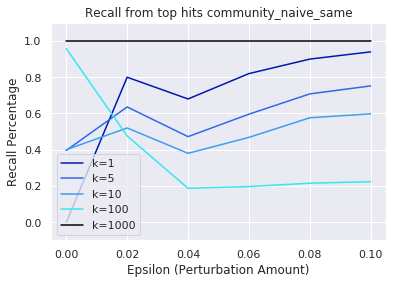

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=1)

mean_top_k_recall = {k: {eps: -1.0 for eps in epsilons} for k in ks}

colors=['#0017ad',
        '#2d67ed',
        '#37a0f0',
        '#37e6f0',
        '#000000'
       ]

for indx, k in enumerate(top_k_recall.keys()):
    epsilons = top_k_recall[k].keys()
    recall_to_plot = []
    for eps in epsilons:        
        recall_to_plot.append(top_k_recall[k][eps])
        
    ax.plot(
        list(epsilons),
        recall_to_plot,
        label="k={}".format(k),
        color=colors[indx],
    )

ax.set_ylabel("Recall Percentage")
ax.set_xlabel("Epsilon (Perturbation Amount)")
ax.set_title("Recall from top hits community_naive_same")
ax.set_ylim([-0.1, 1.1])
ax.legend()
plt.show()


In [6]:
arr = np.reshape(np.array([x for x in range(25)]), (5, 5))
print(arr)
print(arr[np.tril_indices(5, -1)])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 5 10 11 15 16 17 20 21 22 23]


In [7]:
from pprint import PrettyPrinter as pp
pp().pprint(top_k_recall)

{1: {0.0: 0.0, 0.02: 1.0, 0.04: 0.82, 0.06: 0.48, 0.08: 0.6, 0.1: 0.64},
 5: {0.0: 0.292,
     0.02: 0.96,
     0.04: 0.836,
     0.06: 0.7959999999999999,
     0.08: 0.72,
     0.1: 0.26799999999999996},
 10: {0.0: 0.326,
      0.02: 0.98,
      0.04: 0.87,
      0.06: 0.74,
      0.08: 0.6439999999999999,
      0.1: 0.196},
 100: {0.0: 0.494949494949495,
       0.02: 0.9757489707475624,
       0.04: 0.6475128688128688,
       0.06: 0.3176989898989899,
       0.08: 0.17300000000000001,
       0.1: 0.08296410256410257},
 1000: {0.0: 0.494949494949495,
        0.02: 0.9757489707475624,
        0.04: 0.6648521929081913,
        0.06: 0.23455674782827884,
        0.08: 0.08884828893031653,
        0.1: 0.06540767440917751}}


In [8]:
print(identities)

['n009288', 'n002763', 'n000958', 'n002647', 'n008655', 'n003356', 'n007548', 'n008613', 'n000029', 'n009232', 'n005359', 'n003215', 'n005303', 'n005427', 'n001683', 'n001781', 'n009114', 'n004658', 'n002503']


In [9]:
# with h5py.File(path_to_clean.format(id='n008655'), "r") as f1:
#     with h5py.File(path_to_clean.format(id='n000029'), "r") as f2:
#         seaborn.distplot(
#             pairwise_distances(
#                 f1["embeddings"][:],
#                 f2["embeddings"][:]
#             ),
#             color="red",
#             label="diff"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 f1["embeddings"][:],
#                 f1["embeddings"][:]
#             )[np.tril_indices(len(f1["embeddings"][:]), -1)],
#             color="green",
#             label="A self"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 f2["embeddings"][:],
#                 f2["embeddings"][:]
#             )[np.tril_indices(len(f2["embeddings"][:]), -1)],
#             color="lightgreen",
#             label="B self"
#         )
#         plt.legend()

In [10]:
# model = tf.keras.models.load_model("../keras-facenet/model/facenet_keras.h5")
# with h5py.File(path_to_clean.format(id='n008655'), "r") as f1:
#     with h5py.File(path_to_clean.format(id='n000029'), "r") as f2:
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f1["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f2["images"][:])))
#             ),
#             color="red",
#             label="diff"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f1["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f1["images"][:])))
#             )[np.tril_indices(len(f1["embeddings"][:]), -1)],
#             color="green",
#             label="A self"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f2["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f2["images"][:])))
#             )[np.tril_indices(len(f2["embeddings"][:]), -1)],
#             color="lightgreen",
#             label="B self"
#         )
#         plt.legend()